In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy import sparse
from imblearn.over_sampling import RandomOverSampler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (12,8)

In [ ]:
import random
waterborne_columns=[
    'Watery stool', 'dehydration', 'abdominal_cramps', 'nausea', 'vomiting', 'fatigue', 'fever',
  'rice_water_stool','leg_cramps', 'rapid_heart_rate',
]

disease_symptoms={
    'diarrhea':{ 'Watery stool', 'dehydration', 'abdominal_cramps', 'nausea', 'vomiting', 'fatigue', 'fever'},
    'cholera':{ 'Watery stool', 'dehydration','rice_water_stool','leg_cramps','rapid_heart_rate','vomiting'}
}

def generate_sample():
    # Randomly choose a disease
    disease = random.choice(list(disease_symptoms.keys()))
    symptoms = disease_symptoms[disease]

    # Randomly keep 50-100% of the symptoms
    percentage = random.uniform(0.3, 1)
    num_symptoms_to_keep = int(len(symptoms) * percentage)

    # Select a subset of symptoms to include
    selected_symptoms = set(random.sample(symptoms, num_symptoms_to_keep))

    # Create the sample with selected symptoms as 1 and others as 0
    sample = {symptom: 1 if symptom in selected_symptoms else 0 for symptom in waterborne_columns}
    sample['disease'] = disease

    # Return the sample as a frozenset (which can be stored in a set)
    return frozenset(sample.items())

# Create a set to ensure uniqueness
unique_samples = set()

# Continue generating samples until we have 10,000 unique rows
max_attempts = 100000  # The threshold for breaking the loop after too many duplicates
attempts = 0

while len(unique_samples) < 10000:
    sample = generate_sample()
    if sample not in unique_samples:
        unique_samples.add(sample)
        attempts = 0  # Reset attempts when a unique sample is added
    else:
        attempts += 1

    # Break the loop if too many consecutive duplicate samples are generated
    if attempts >= max_attempts:
        print(f"Breaking the loop after {attempts} consecutive duplicates.")
        break

# Convert the frozensets back into dictionaries
data = [dict(sample) for sample in unique_samples]

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to CSV
df.to_csv('/content/drive/MyDrive/1_data_ml/flood_2disease_dataset.csv', index=False)

print(f"Dataset generated with {len(df)} unique rows and saved as 'waterborne_disease_partial_match_dataset.csv'.")


Breaking the loop after 100000 consecutive duplicates.
Dataset generated with 181 unique rows and saved as 'waterborne_disease_partial_match_dataset.csv'.


In [ ]:
initial_dataset=pd.read_csv('/content/drive/MyDrive/1_data_ml/flood_2disease_dataset.csv')
initial_dataset.head()

,disease,fatigue,dehydration,leg_cramps,rapid_heart_rate,vomiting,fever,abdominal_cramps,rice_water_stool,Watery stool,nausea
0,diarrhea,0,0,0,0,1,0,1,0,1,1
1,diarrhea,0,1,0,0,0,0,1,0,1,0
2,diarrhea,0,1,0,0,1,0,0,0,1,1
3,cholera,0,1,1,0,0,0,0,1,1,0
4,cholera,0,1,0,0,0,0,0,0,0,0


In [ ]:
initial_dataset.drop(columns=['nausea'],inplace=True)

In [ ]:
initial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   disease           181 non-null    object
 1   fatigue           181 non-null    int64 
 2   dehydration       181 non-null    int64 
 3   leg_cramps        181 non-null    int64 
 4   rapid_heart_rate  181 non-null    int64 
 5   vomiting          181 non-null    int64 
 6   fever             181 non-null    int64 
 7   abdominal_cramps  181 non-null    int64 
 8   rice_water_stool  181 non-null    int64 
 9   Watery stool      181 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 14.3+ KB


In [ ]:
initial_dataset.describe()

,fatigue,dehydration,leg_cramps,rapid_heart_rate,vomiting,fever,abdominal_cramps,rice_water_stool,Watery stool
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.342541,0.513812,0.171271,0.171271,0.513812,0.342541,0.342541,0.171271,0.513812
std,0.475876,0.501196,0.377790,0.377790,0.501196,0.475876,0.475876,0.377790,0.501196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

# Create a profile report
profile = ProfileReport(initial_dataset, title="Pandas Profiling Report")

# Save the report to a file
profile.to_file('/content/drive/MyDrive/1_data_ml/flood_ydata.html')


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 68.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=fd5e3b45c34549c8b6a481b664c1782c36a7802269a6a98056ebbe2e96da9456
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
initial_dataset.duplicated().sum()

56

In [ ]:
y=initial_dataset['disease']

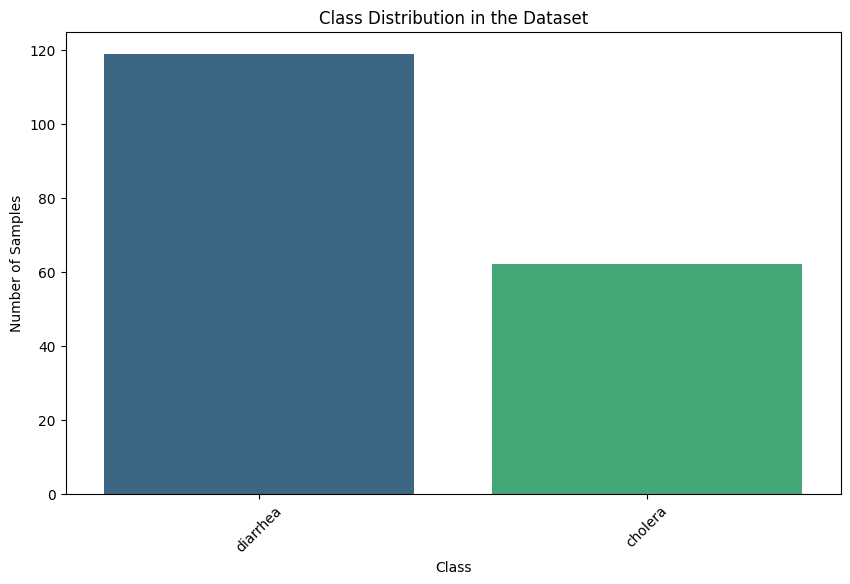

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the class distribution from the 'fish' column
class_distribution = y.value_counts()

# Create a bar plot for the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# Rotate x-axis labels for better readability if necessary
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
label_encoder = LabelEncoder()
initial_dataset['disease_encoded'] = label_encoder.fit_transform(initial_dataset['disease'])

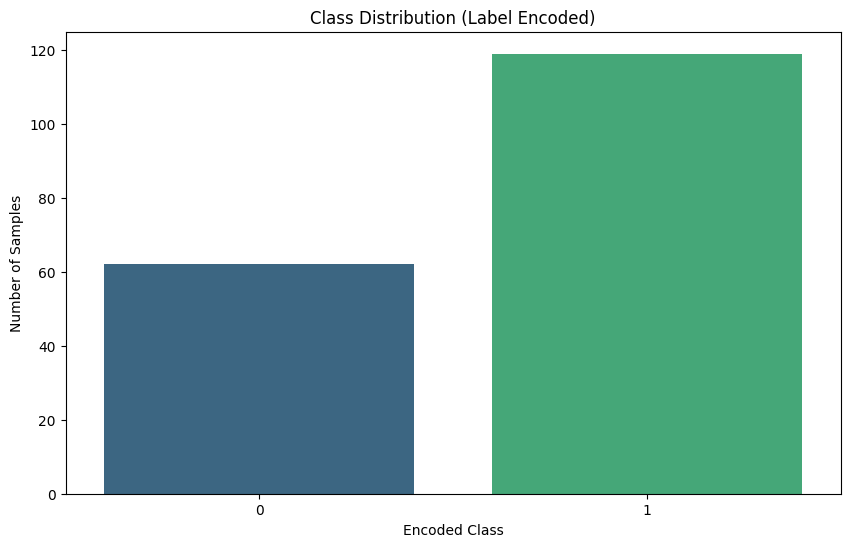

Label Encoding Mapping:
cholera: 0
diarrhea: 1


In [ ]:


class_distribution = initial_dataset['disease_encoded'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title('Class Distribution (Label Encoded)')
plt.xlabel('Encoded Class')
plt.ylabel('Number of Samples')


plt.show()

print("Label Encoding Mapping:")
for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")


In [ ]:
X = initial_dataset.drop(['disease', 'disease_encoded'], axis=1)
y = initial_dataset['disease_encoded']



In [ ]:
print(X.shape)

(181, 9)


In [ ]:
X.duplicated().sum()


63

In [ ]:
y.duplicated().sum()

179

In [ ]:
X=X.drop_duplicates()


In [ ]:

y= y.loc[X.index]


X= X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [ ]:
print(X.shape,y.shape)

(118, 9) (118,)


In [ ]:
X.drop_duplicates()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Original dataset class distribution: Counter({1: 48, 0: 46})
Resampled dataset class distribution: Counter({0: 48, 1: 48})


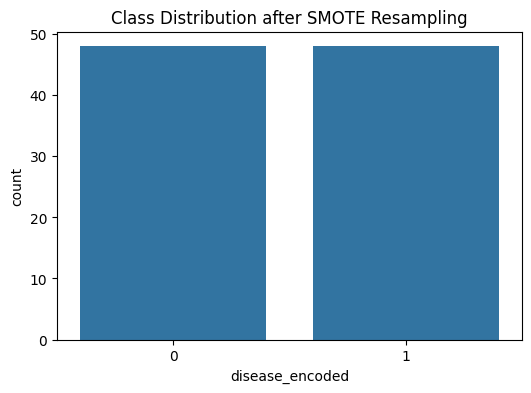

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Count the number of instances in each class before and after SMOTE
print('Original dataset class distribution:', Counter(y_train))
print('Resampled dataset class distribution:', Counter(y_train_resampled))

# Visualizing the resampled data distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution after SMOTE Resampling')
plt.show()


In [ ]:
initial_dataset.duplicated().sum()

56

In [ ]:
X.duplicated().sum()

0

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

TensorFlow model trained and converted to TFLite successfully.


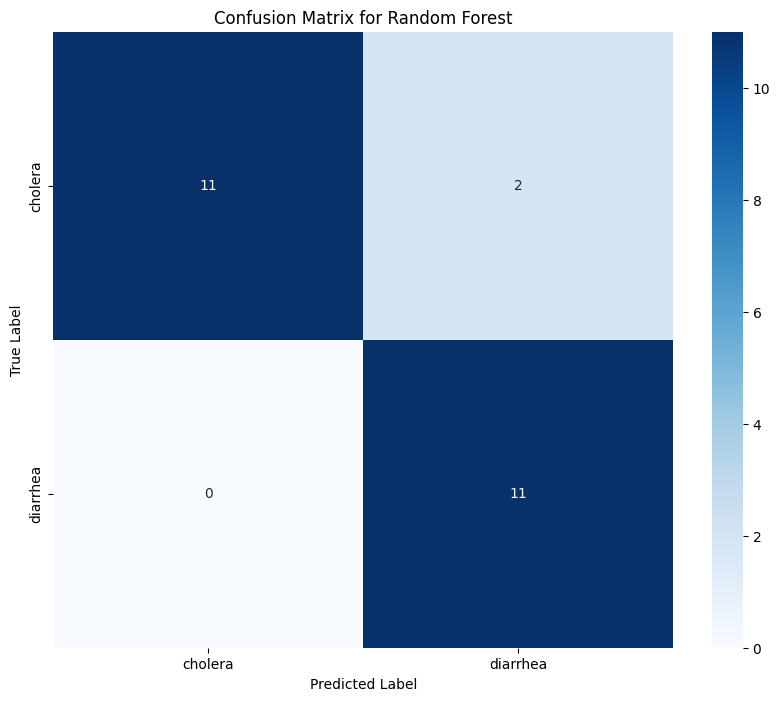

Accuracy for Random Forest: 0.9167


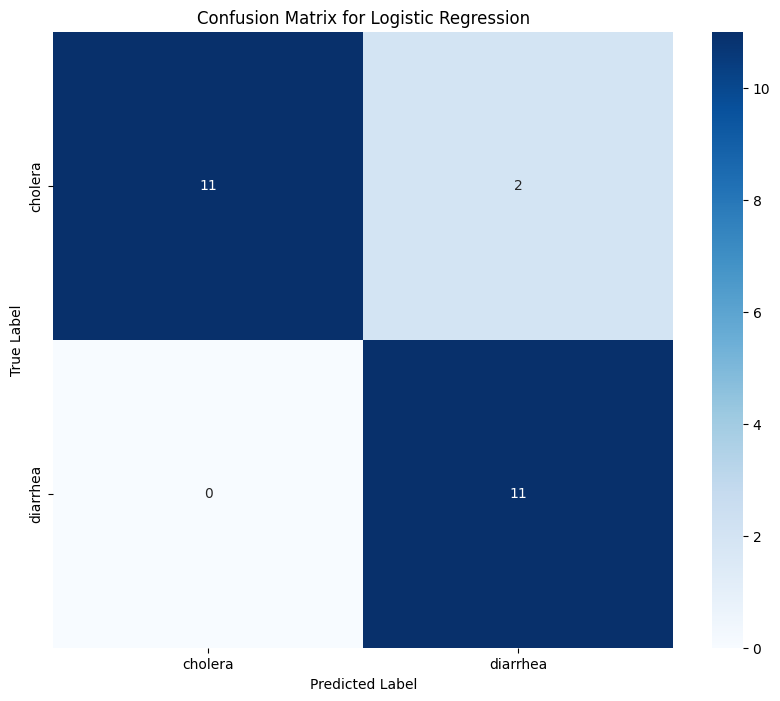

Accuracy for Logistic Regression: 0.9167


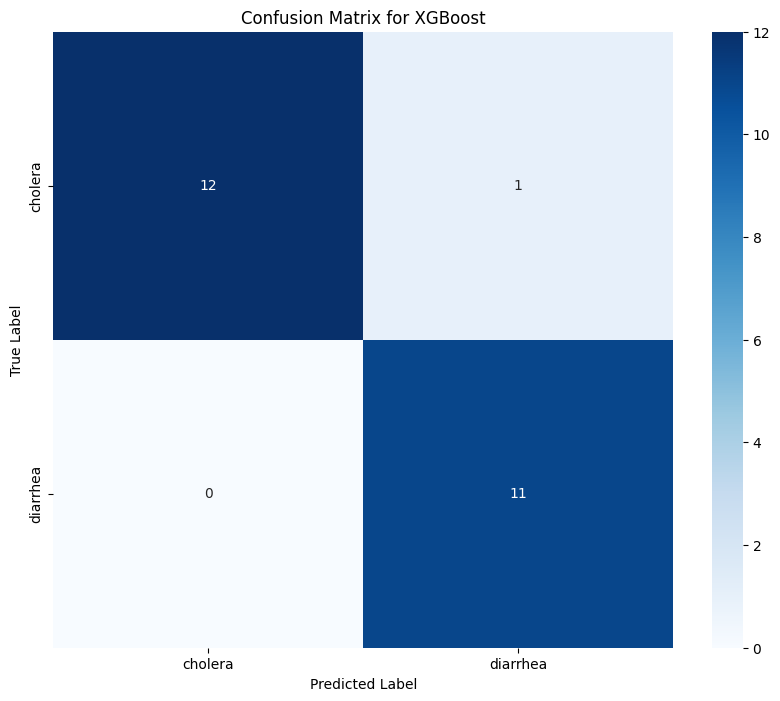

Accuracy for XGBoost: 0.9583


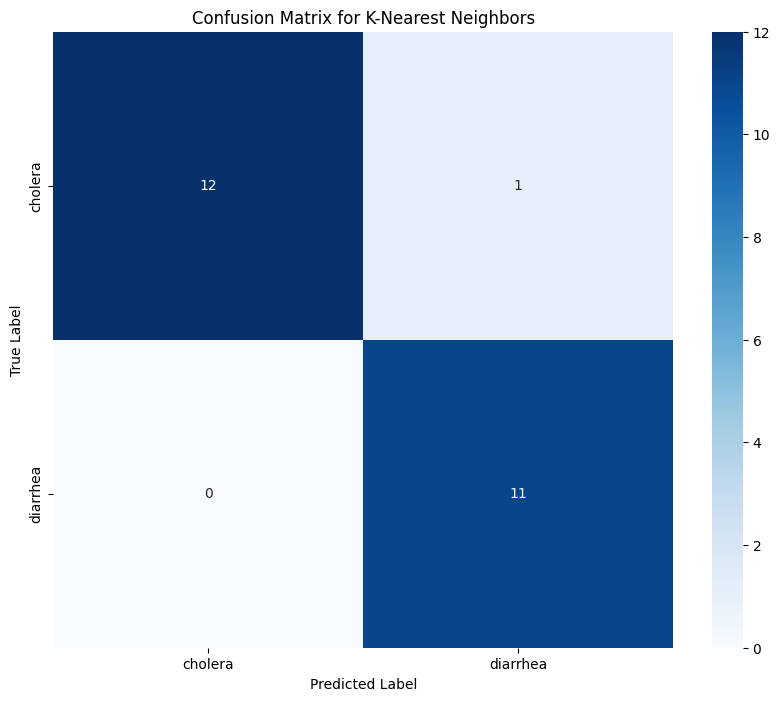

Accuracy for K-Nearest Neighbors: 0.9583


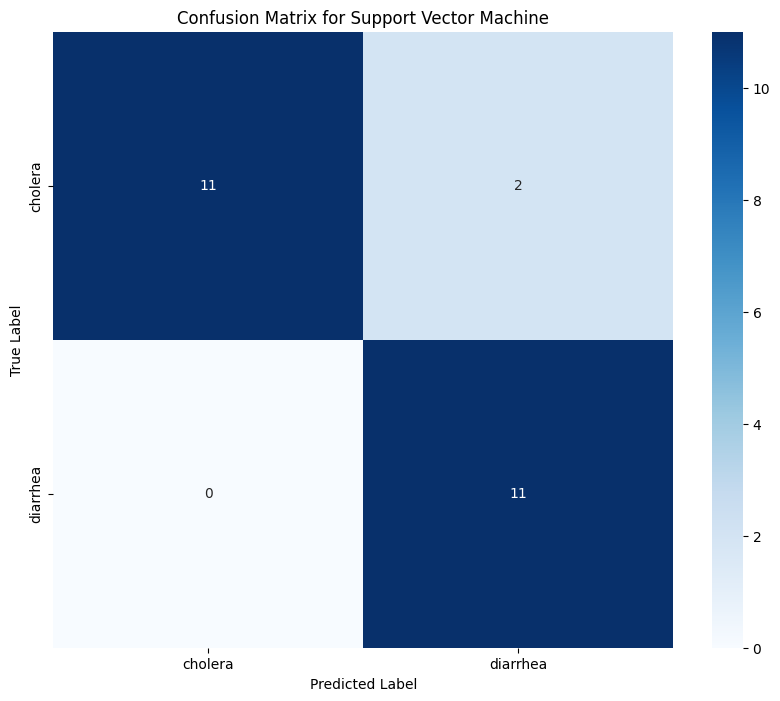

Accuracy for Support Vector Machine: 0.9167


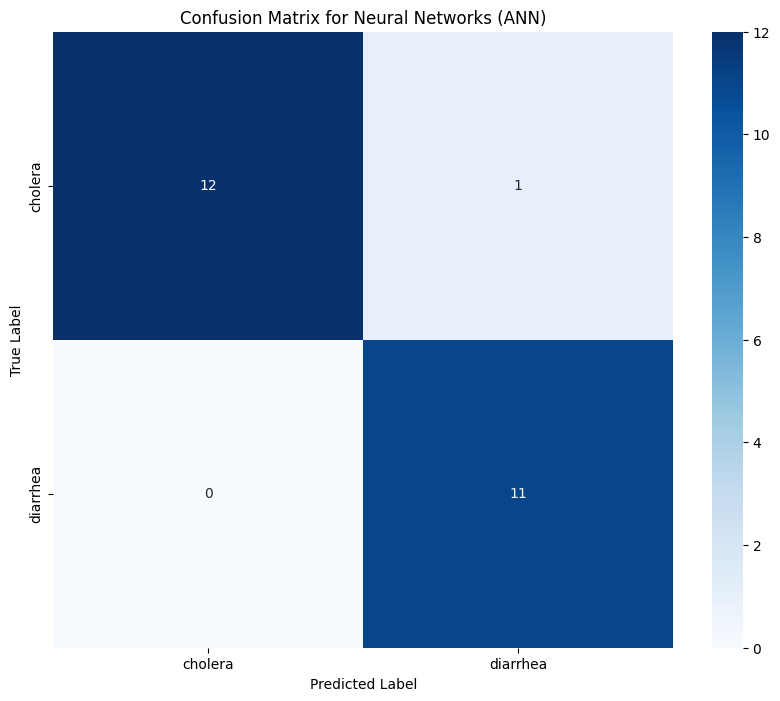

Accuracy for Neural Networks (ANN): 0.9583
Accuracy for Random Forest: 0.9167


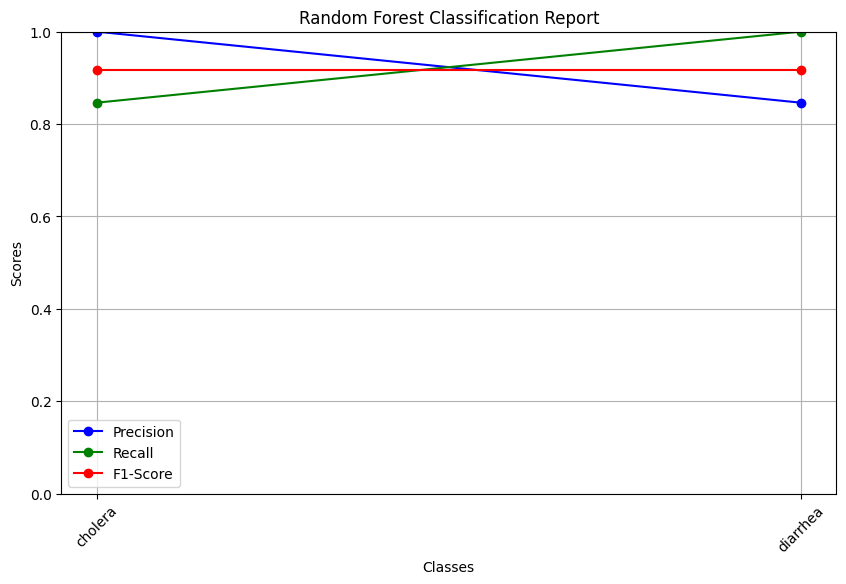

Accuracy for Logistic Regression: 0.9167


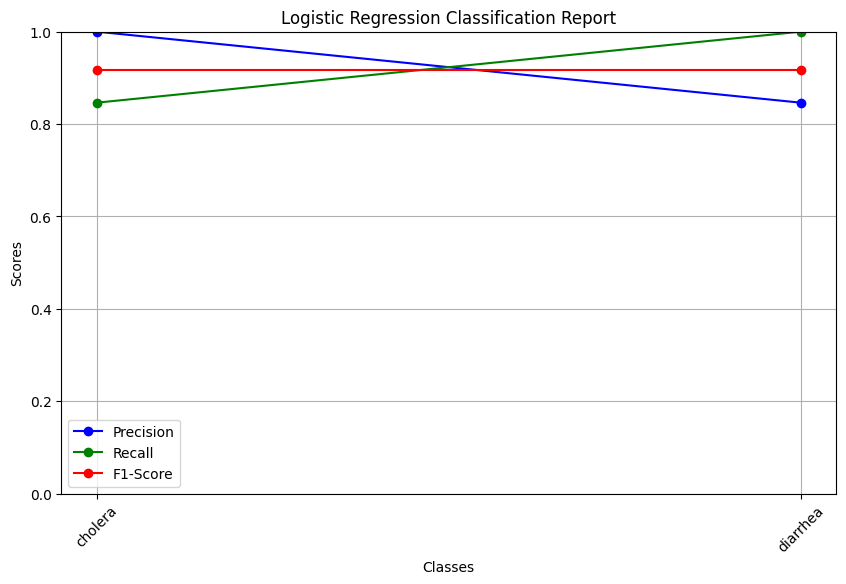

Accuracy for XGBoost: 0.9583


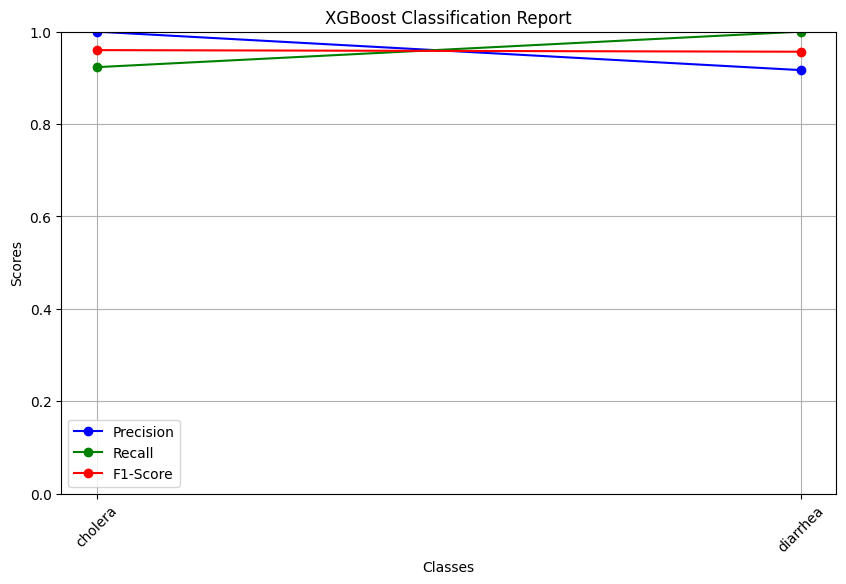

Accuracy for K-Nearest Neighbors: 0.9583


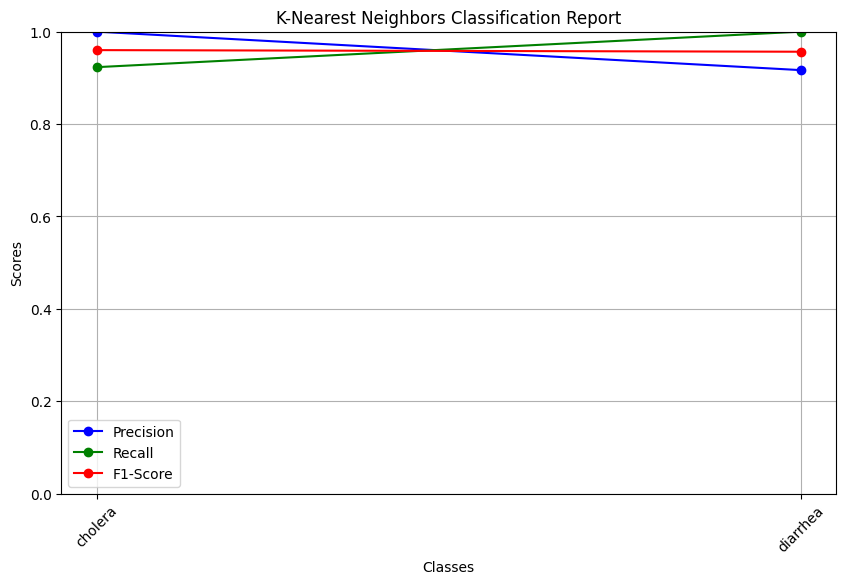

Accuracy for Support Vector Machine: 0.9167


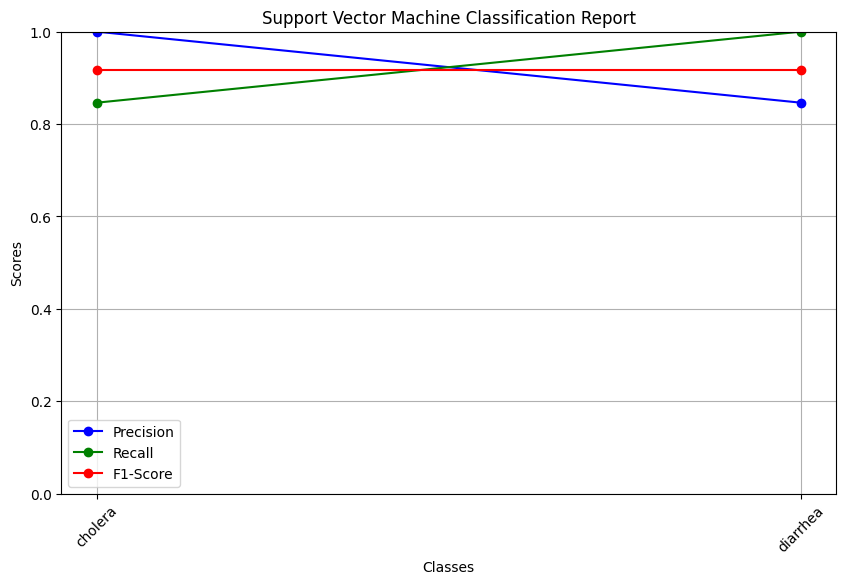

Accuracy for Neural Networks (ANN): 0.9583


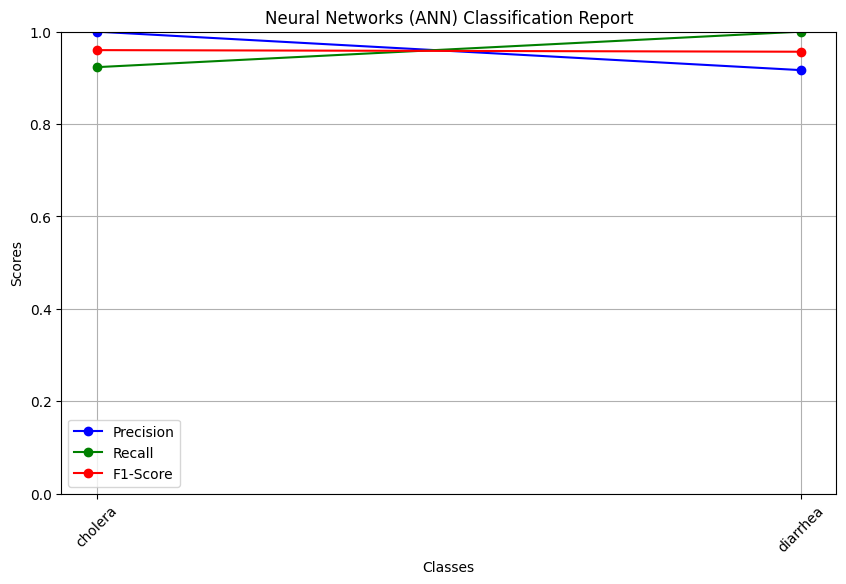

In [ ]:
# Step 1: Train the models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier()

log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Step 2: Make predictions
log_reg_pred = log_reg.predict(X_test)
random_forest_pred = random_forest.predict(X_test)

# Step 3: Train additional models (XGBoost, KNN, SVM, ANN)
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Neural Networks (Artificial Neural Network - ANN)
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann.fit(X_train, y_train)
ann_pred = ann.predict(X_test)

# Step 4: Generate classification reports with accuracy
def classification_report_with_accuracy(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    print(f'Accuracy for {model_name}: {accuracy:.4f}')
    return pd.DataFrame(report).transpose()

# Step 5: Generate confusion matrix and classification report for a given model
def plot_confusion_matrix_and_report(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Show classification report with accuracy
    report_df = classification_report_with_accuracy(y_test, y_pred, model_name)
    return report_df


print("TensorFlow model trained and converted to TFLite successfully.")
# Step 6: Plot confusion matrix and classification report for each model
plot_confusion_matrix_and_report(y_test, random_forest_pred, 'Random Forest')
plot_confusion_matrix_and_report(y_test, log_reg_pred, 'Logistic Regression')
plot_confusion_matrix_and_report(y_test, xgb_pred, 'XGBoost')
plot_confusion_matrix_and_report(y_test, knn_pred, 'K-Nearest Neighbors')
plot_confusion_matrix_and_report(y_test, svm_pred, 'Support Vector Machine')
plot_confusion_matrix_and_report(y_test, ann_pred, 'Neural Networks (ANN)')

# Step 7: Visualize classification report metrics for each model
def plot_classification_metrics(report_df, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(report_df.index[:-3], report_df['precision'][:-3], marker='o', label='Precision', color='b')
    plt.plot(report_df.index[:-3], report_df['recall'][:-3], marker='o', label='Recall', color='g')
    plt.plot(report_df.index[:-3], report_df['f1-score'][:-3], marker='o', label='F1-Score', color='r')
    plt.title(f'{model_name} Classification Report')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot classification metrics for all models
models_predictions = {
    'Random Forest': random_forest_pred,
    'Logistic Regression': log_reg_pred,
    'XGBoost': xgb_pred,
    'K-Nearest Neighbors': knn_pred,
    'Support Vector Machine': svm_pred,
    'Neural Networks (ANN)': ann_pred
}

for model_name, y_pred in models_predictions.items():
    report_df = classification_report_with_accuracy(y_test, y_pred, model_name)
    plot_classification_metrics(report_df, model_name)


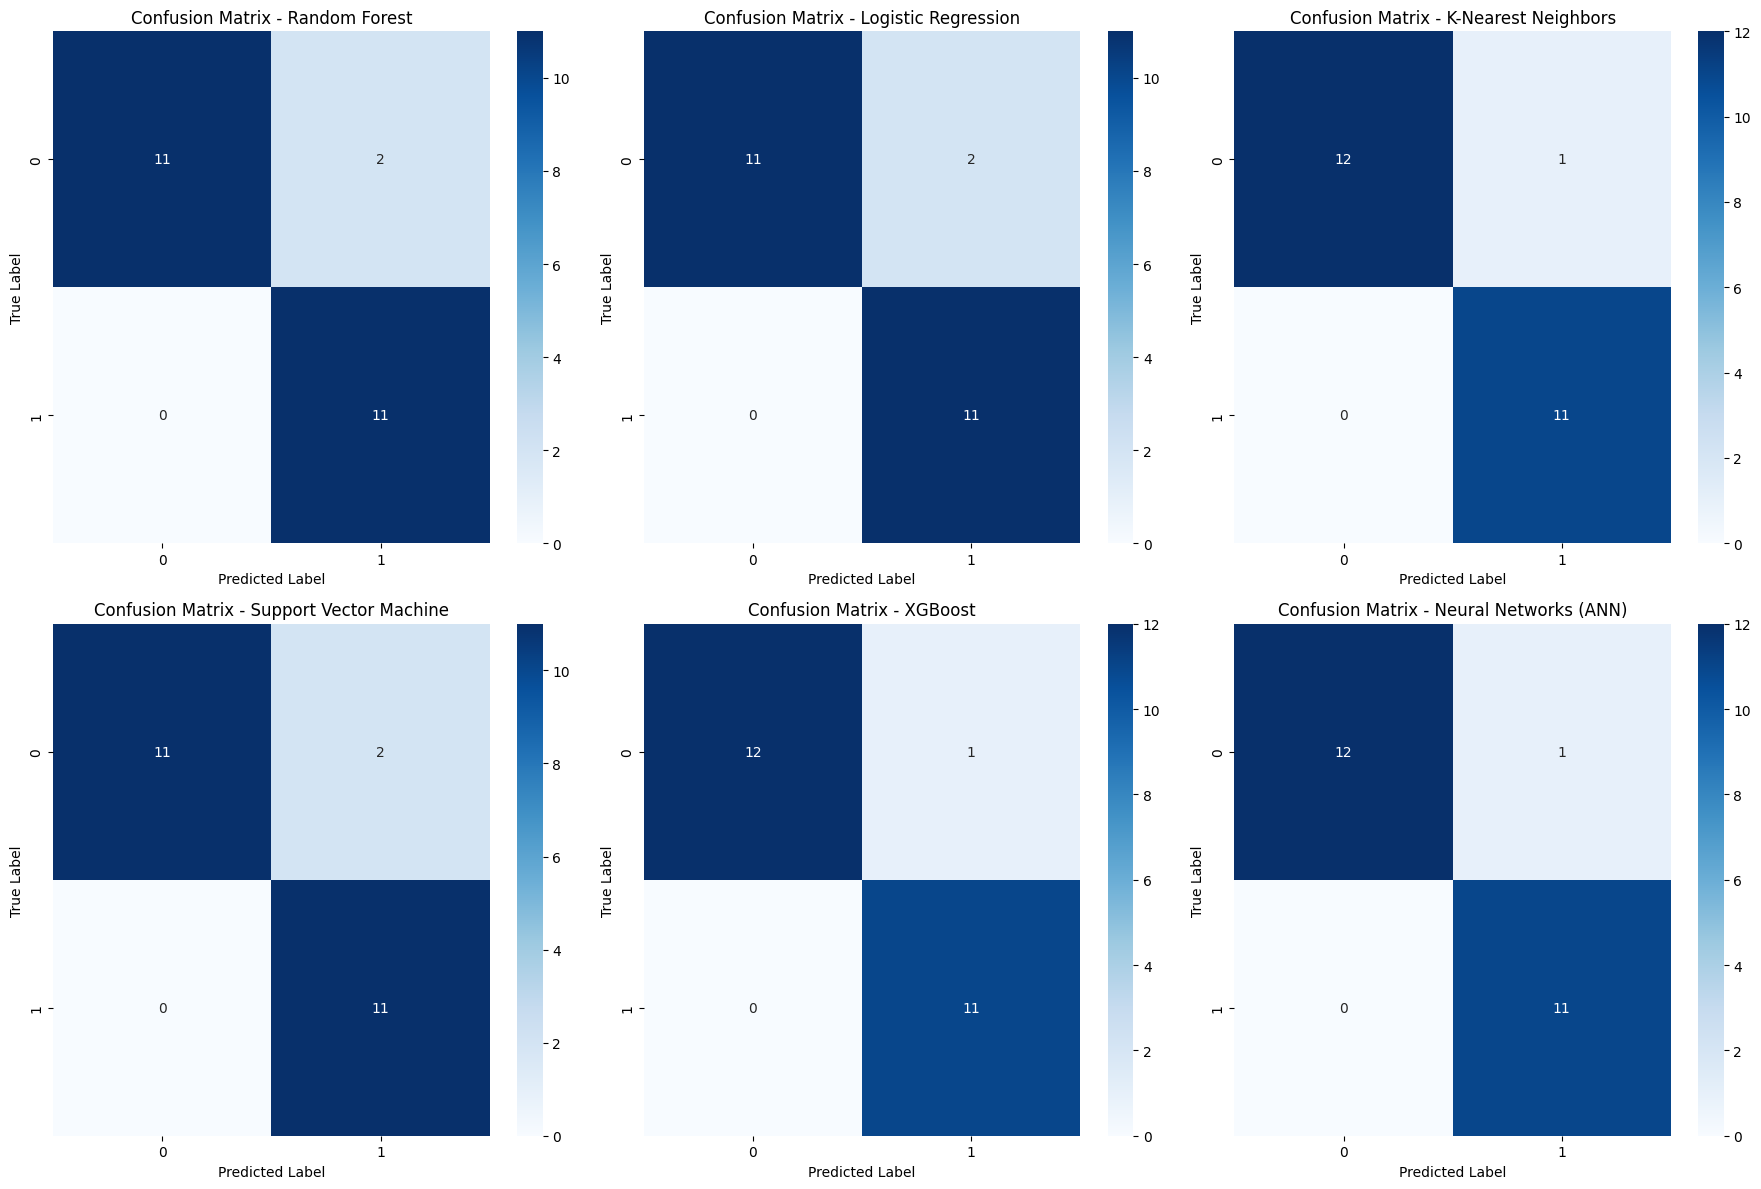

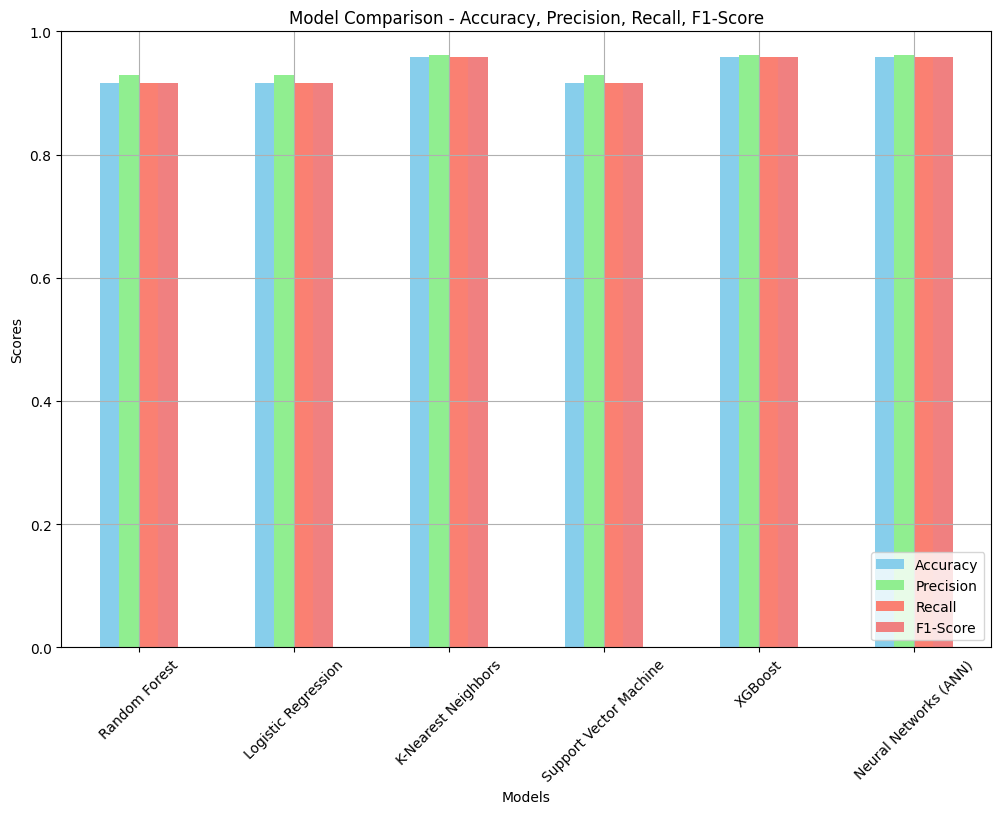

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Assuming the data is already split into training and testing sets: X_train, X_test, y_train, y_test
# Assuming the label_encoder is used to encode the classes: label_encoder

# Step 1: Train the models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', probability=True)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Fit the models
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
ann.fit(X_train, y_train)

# Step 2: Make predictions
log_reg_pred = log_reg.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
knn_pred = knn.predict(X_test)
svm_pred = svm.predict(X_test)
xgb_pred = xgb.predict(X_test)
ann_pred = ann.predict(X_test)

# Step 3: Define functions for classification report and confusion matrix plotting
def classification_report_with_accuracy(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    print(f'Accuracy for {model_name}: {accuracy:.4f}')
    return pd.DataFrame(report).transpose()

def plot_confusion_matrix_and_report(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    report_df = classification_report_with_accuracy(y_test, y_pred, model_name)
    return report_df

# Step 4: Plot confusion matrices for all models together
def plot_all_confusion_matrices(models_predictions, y_test):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()  # Flatten the 2D grid of axes for easier iteration

    for i, (model_name, y_pred) in enumerate(models_predictions.items()):
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {model_name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Step 5: Get classification metrics for all models
def get_classification_metrics(models_predictions, y_test):
    metrics_dict = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': []
    }

    for model_name, y_pred in models_predictions.items():
        report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']

        metrics_dict['Model'].append(model_name)
        metrics_dict['Accuracy'].append(accuracy)
        metrics_dict['Precision'].append(precision)
        metrics_dict['Recall'].append(recall)
        metrics_dict['F1-Score'].append(f1_score)

    return pd.DataFrame(metrics_dict)

# Step 6: Plot metrics comparison
def plot_metrics_comparison(metrics_df):
    metrics_df.set_index('Model', inplace=True)
    metrics_df.plot(kind='bar', figsize=(12, 8), color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])
    plt.title('Model Comparison - Accuracy, Precision, Recall, F1-Score')
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Step 7: Generate metrics for all models
models_predictions = {
    'Random Forest': random_forest_pred,
    'Logistic Regression': log_reg_pred,
    'K-Nearest Neighbors': knn_pred,
    'Support Vector Machine': svm_pred,
    'XGBoost': xgb_pred,
    'Neural Networks (ANN)': ann_pred
}

# Step 8: Visualize confusion matrices for all models
plot_all_confusion_matrices(models_predictions, y_test)

# Step 9: Visualize comparison of metrics (accuracy, precision, recall, F1-score)
metrics_df = get_classification_metrics(models_predictions, y_test)
plot_metrics_comparison(metrics_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 48, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510638 -> initscore=0.042560
[LightGBM] [Info] Start training from score 0.042560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

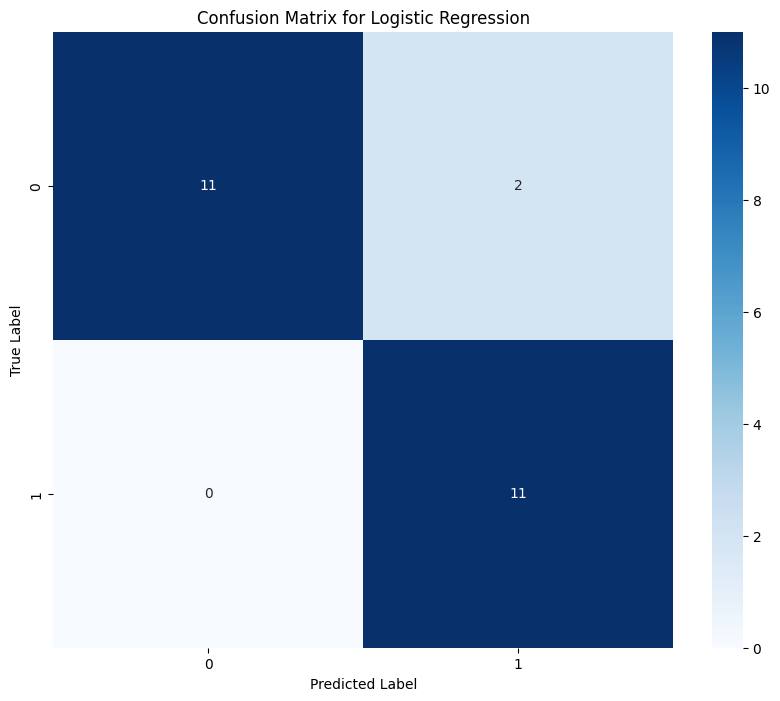

Accuracy for Logistic Regression: 0.9167


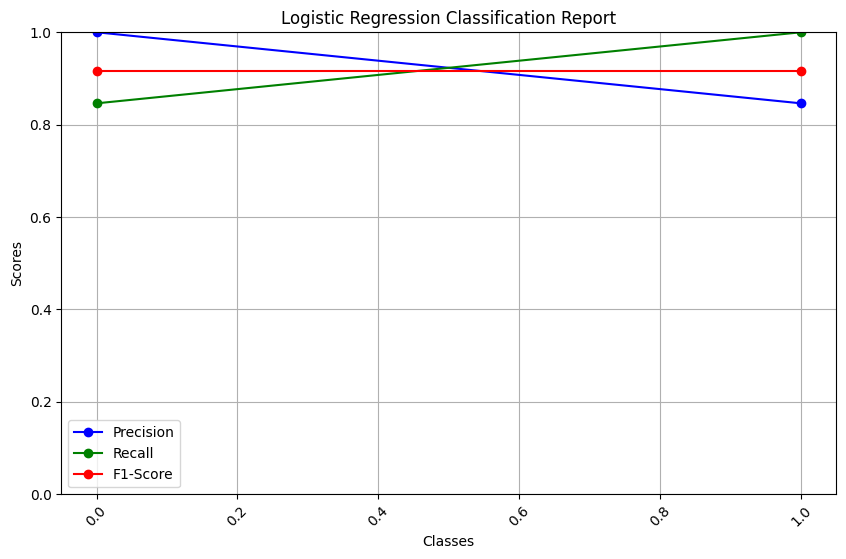

Model: Random Forest


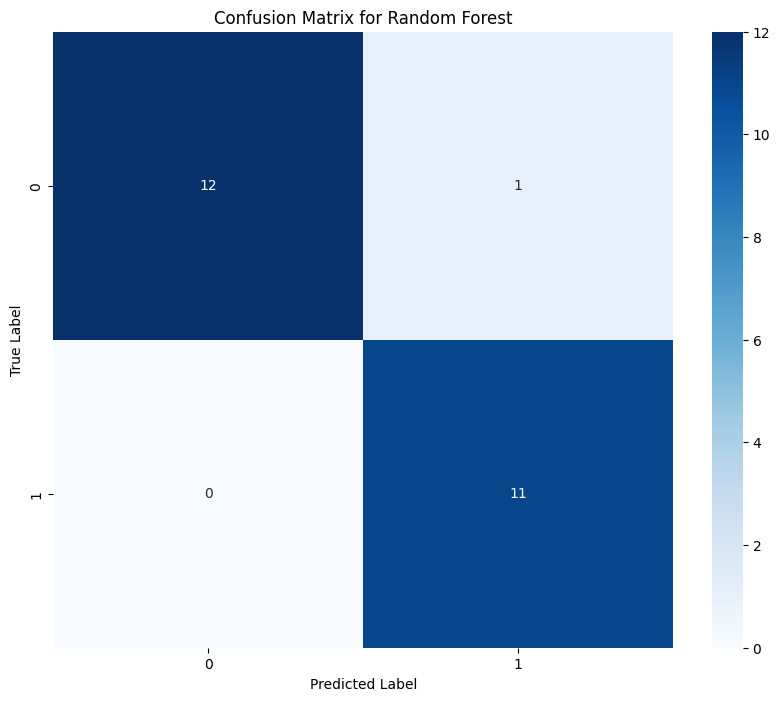

Accuracy for Random Forest: 0.9583


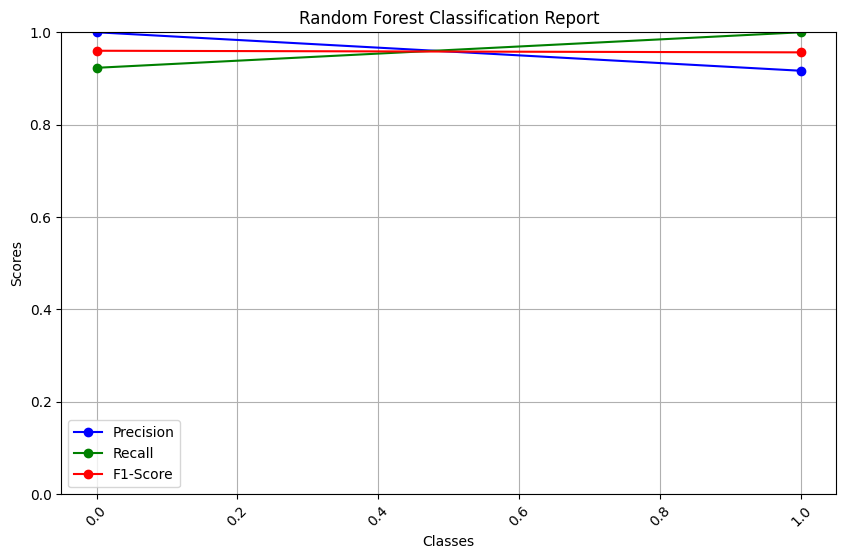

Model: XGBoost


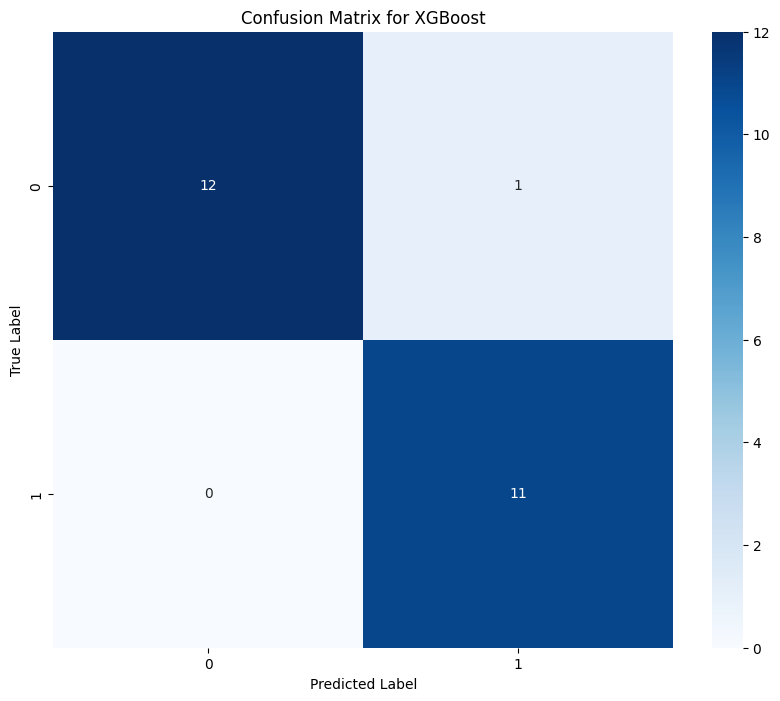

Accuracy for XGBoost: 0.9583


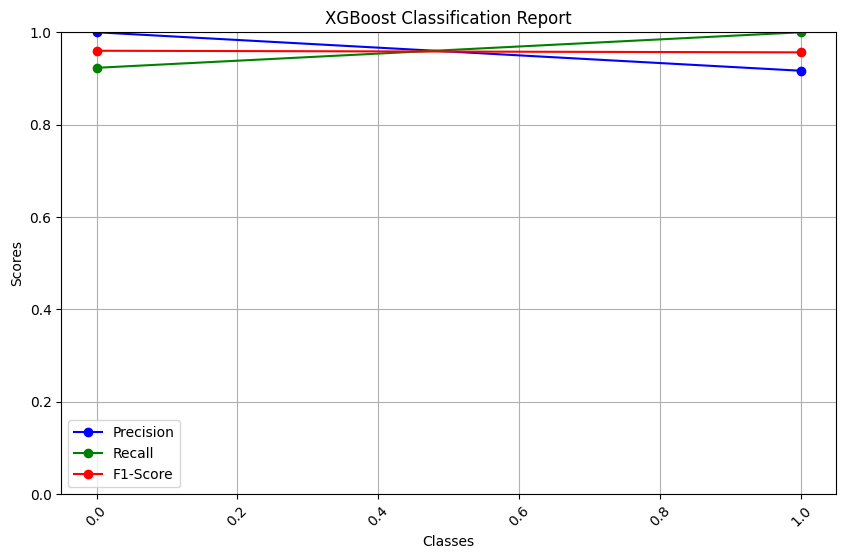

Model: LightGBM


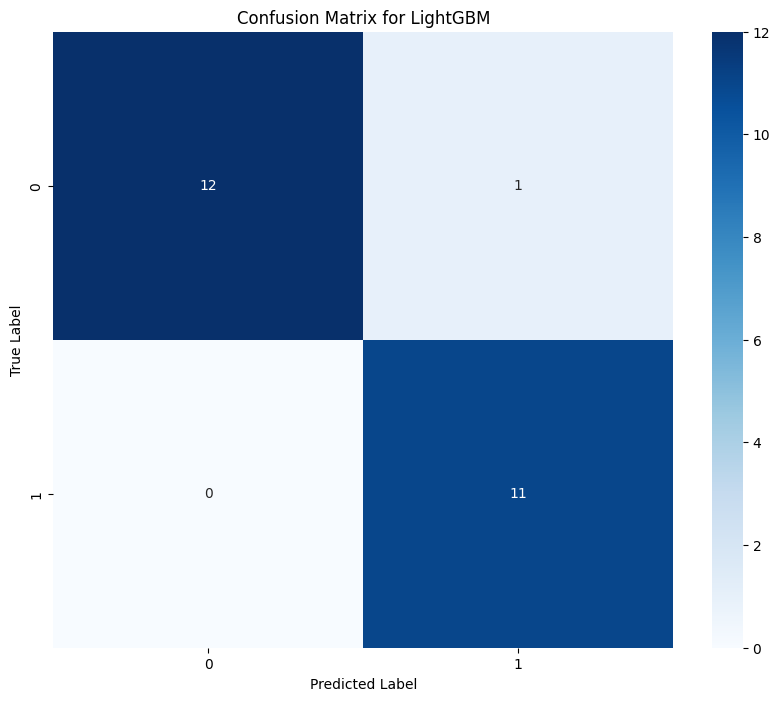

Accuracy for LightGBM: 0.9583


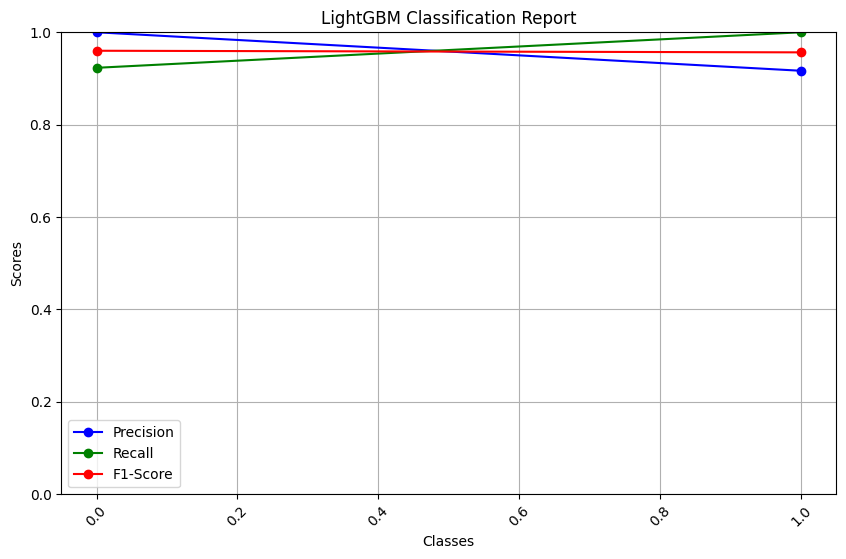

Model: CatBoost


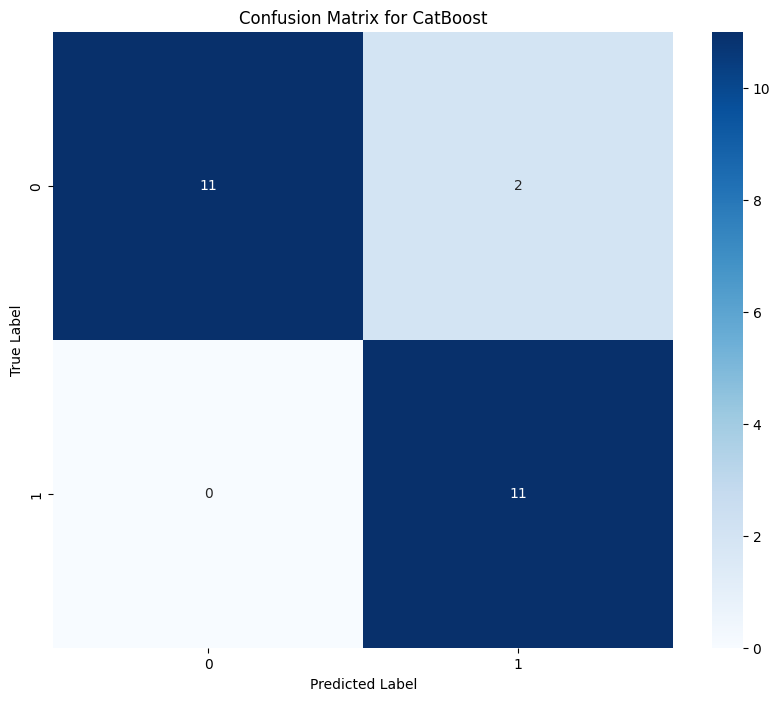

Accuracy for CatBoost: 0.9167


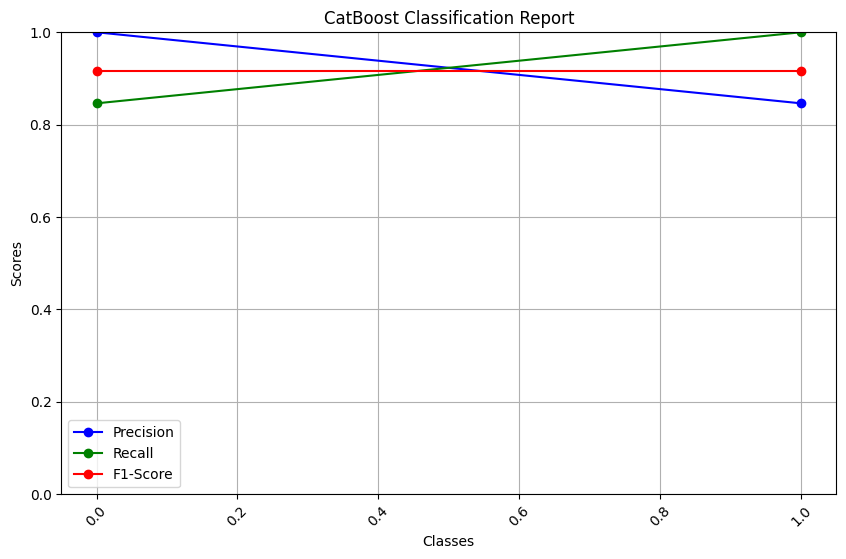

Model: K-Nearest Neighbors


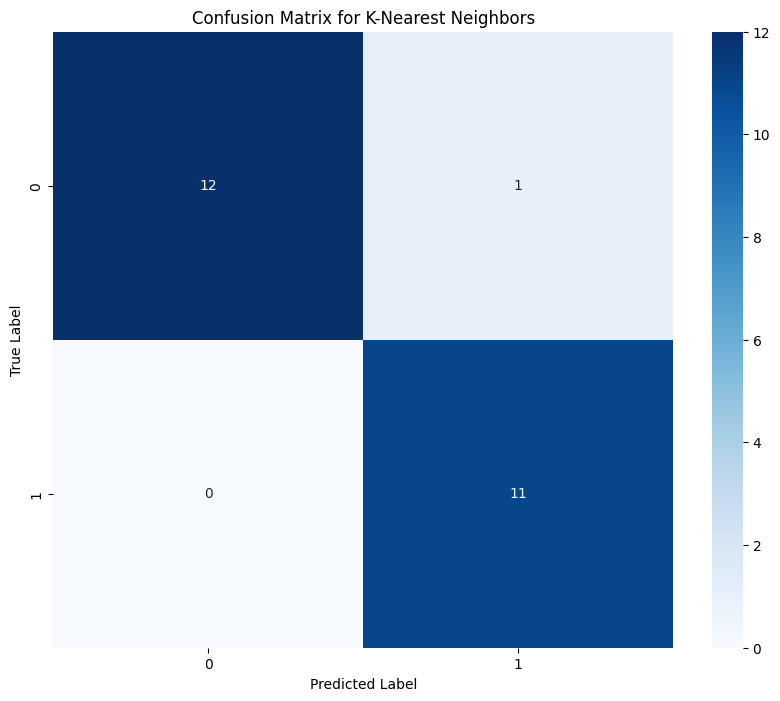

Accuracy for K-Nearest Neighbors: 0.9583


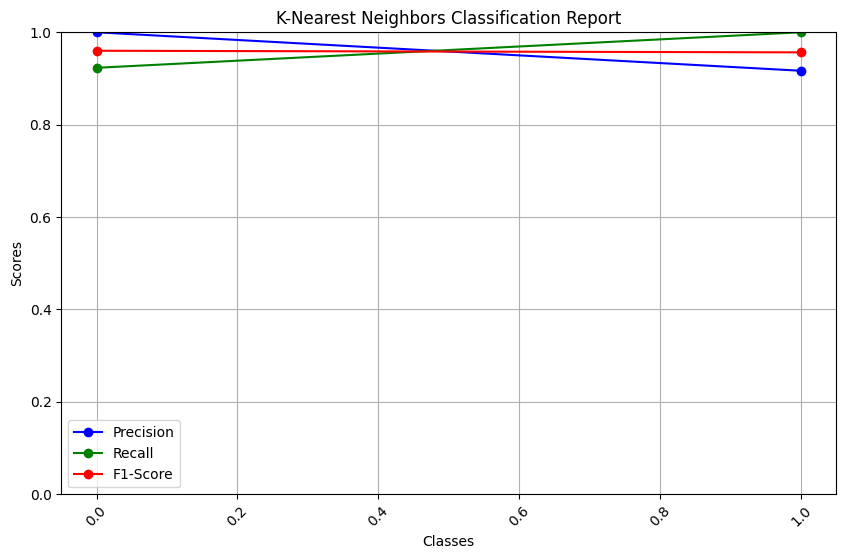

Model: Support Vector Machine


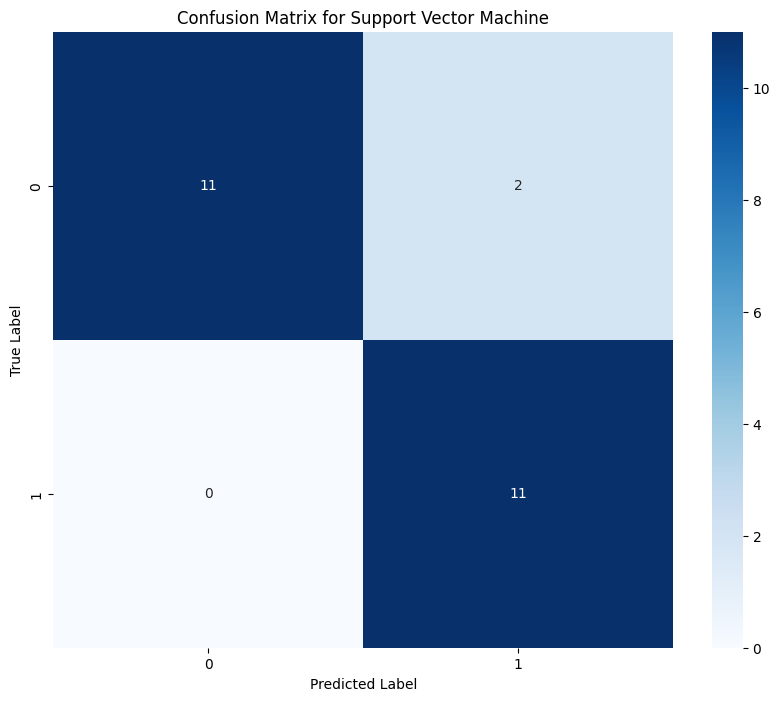

Accuracy for Support Vector Machine: 0.9167


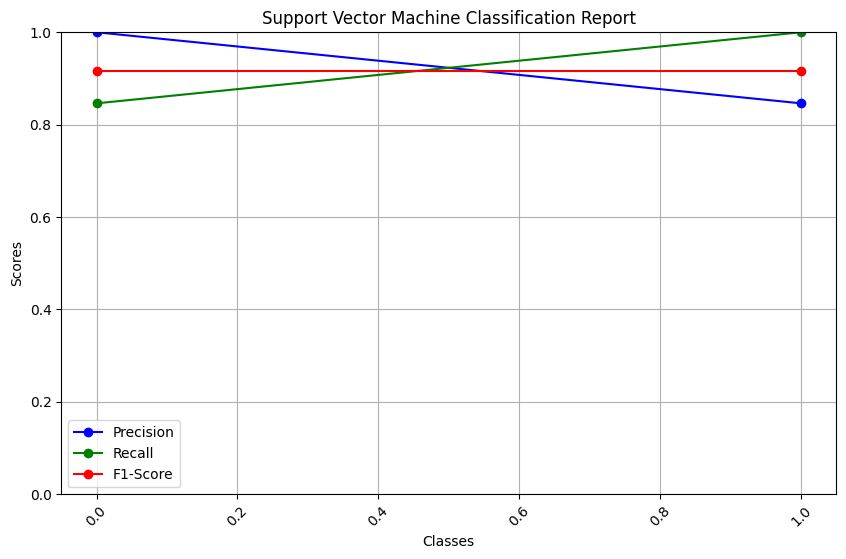

Model: Neural Networks (ANN)


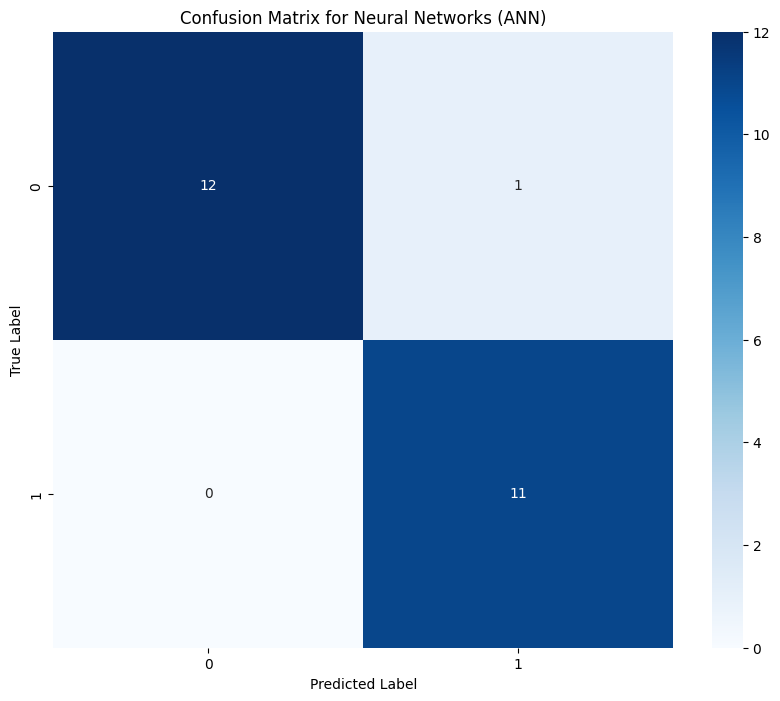

Accuracy for Neural Networks (ANN): 0.9583


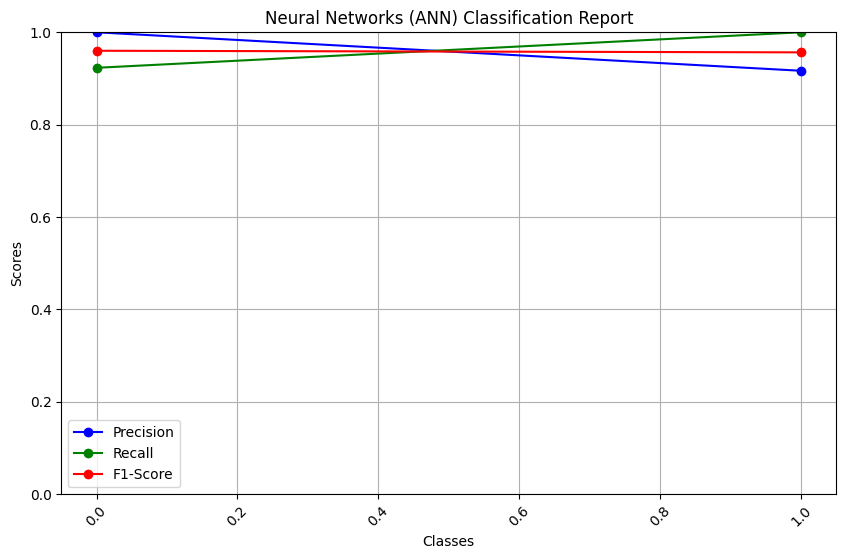

Model: Naive Bayes


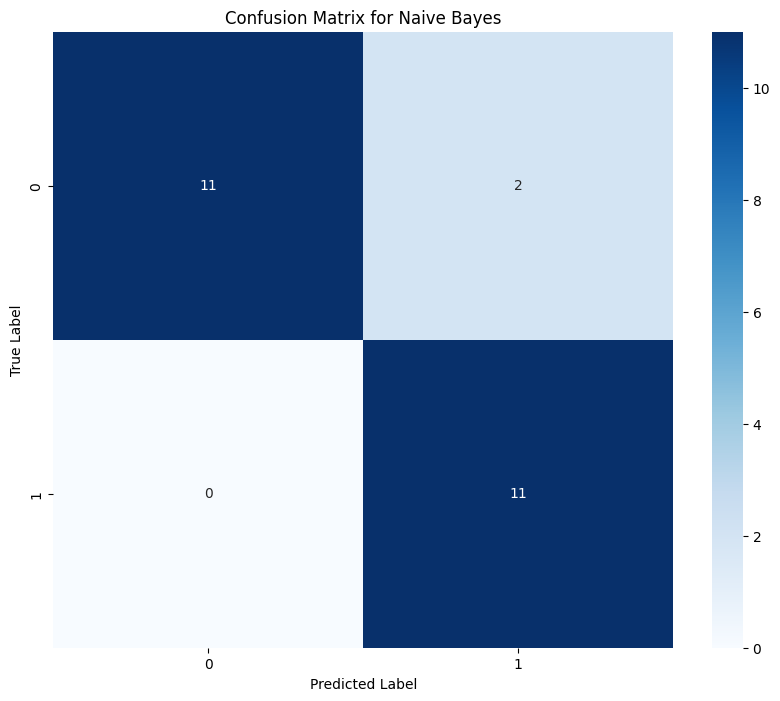

Accuracy for Naive Bayes: 0.9167


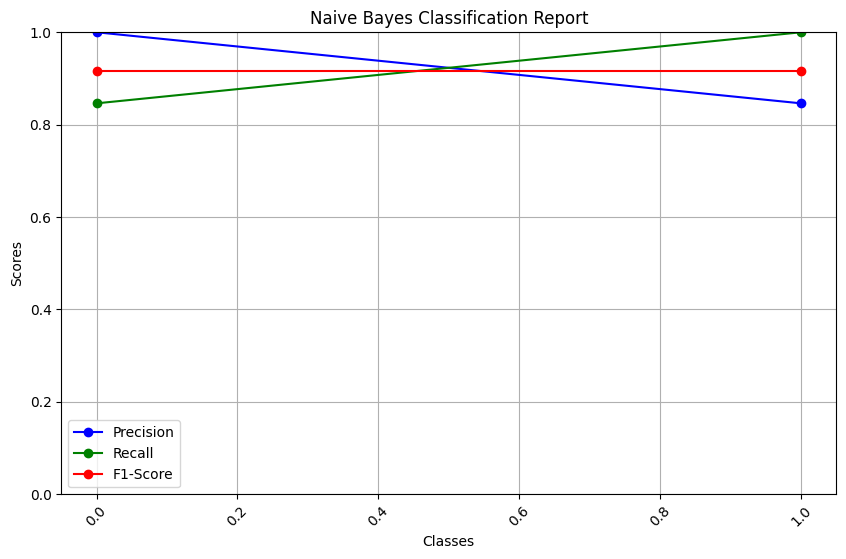

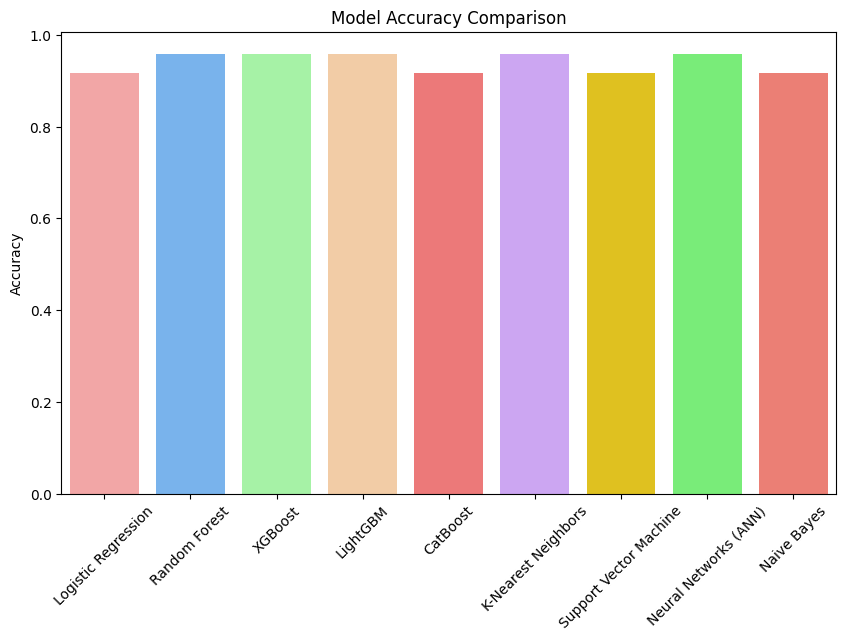

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Step 1: Train the models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lgbm = LGBMClassifier()
catboost = CatBoostClassifier(verbose=0)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', probability=True)
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nb = GaussianNB()

# Step 2: Train and predict for each model
models = {
    'Logistic Regression': log_reg,
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'CatBoost': catboost,
    'K-Nearest Neighbors': knn,
    'Support Vector Machine': svm,
    'Neural Networks (ANN)': ann,
    'Naive Bayes': nb
}

# Assuming your data is loaded and split into X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test should be defined in your preprocessing step
# Example: X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Fit models and make predictions
predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions[model_name] = model.predict(X_test)

# Step 3: Function to generate classification reports with accuracy
def classification_report_with_accuracy(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    print(f'Accuracy for {model_name}: {accuracy:.4f}')
    return pd.DataFrame(report).transpose()

# Step 4: Plot confusion matrix and classification report for each model
def plot_confusion_matrix_and_report(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Show classification report with accuracy
    report_df = classification_report_with_accuracy(y_test, y_pred, model_name)
    return report_df

# Step 5: Visualize classification report metrics for each model
def plot_classification_metrics(report_df, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(report_df.index[:-3], report_df['precision'][:-3], marker='o', label='Precision', color='b')
    plt.plot(report_df.index[:-3], report_df['recall'][:-3], marker='o', label='Recall', color='g')
    plt.plot(report_df.index[:-3], report_df['f1-score'][:-3], marker='o', label='F1-Score', color='r')
    plt.title(f'{model_name} Classification Report')
    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 6: Plot confusion matrix and classification report for all models
for model_name, y_pred in predictions.items():
    print(f"Model: {model_name}")
    report_df = plot_confusion_matrix_and_report(y_test, y_pred, model_name)
    plot_classification_metrics(report_df, model_name)

# Step 7: Summarize accuracy for all models and visualize with different colors
model_accuracies = {model_name: accuracy_score(y_test, y_pred) for model_name, y_pred in predictions.items()}

# Define custom colors for each model
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FF6666', '#CC99FF', '#FFD700', '#66FF66', '#FF6F61']

plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 48, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510638 -> initscore=0.042560
[LightGBM] [Info] Start training from score 0.042560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

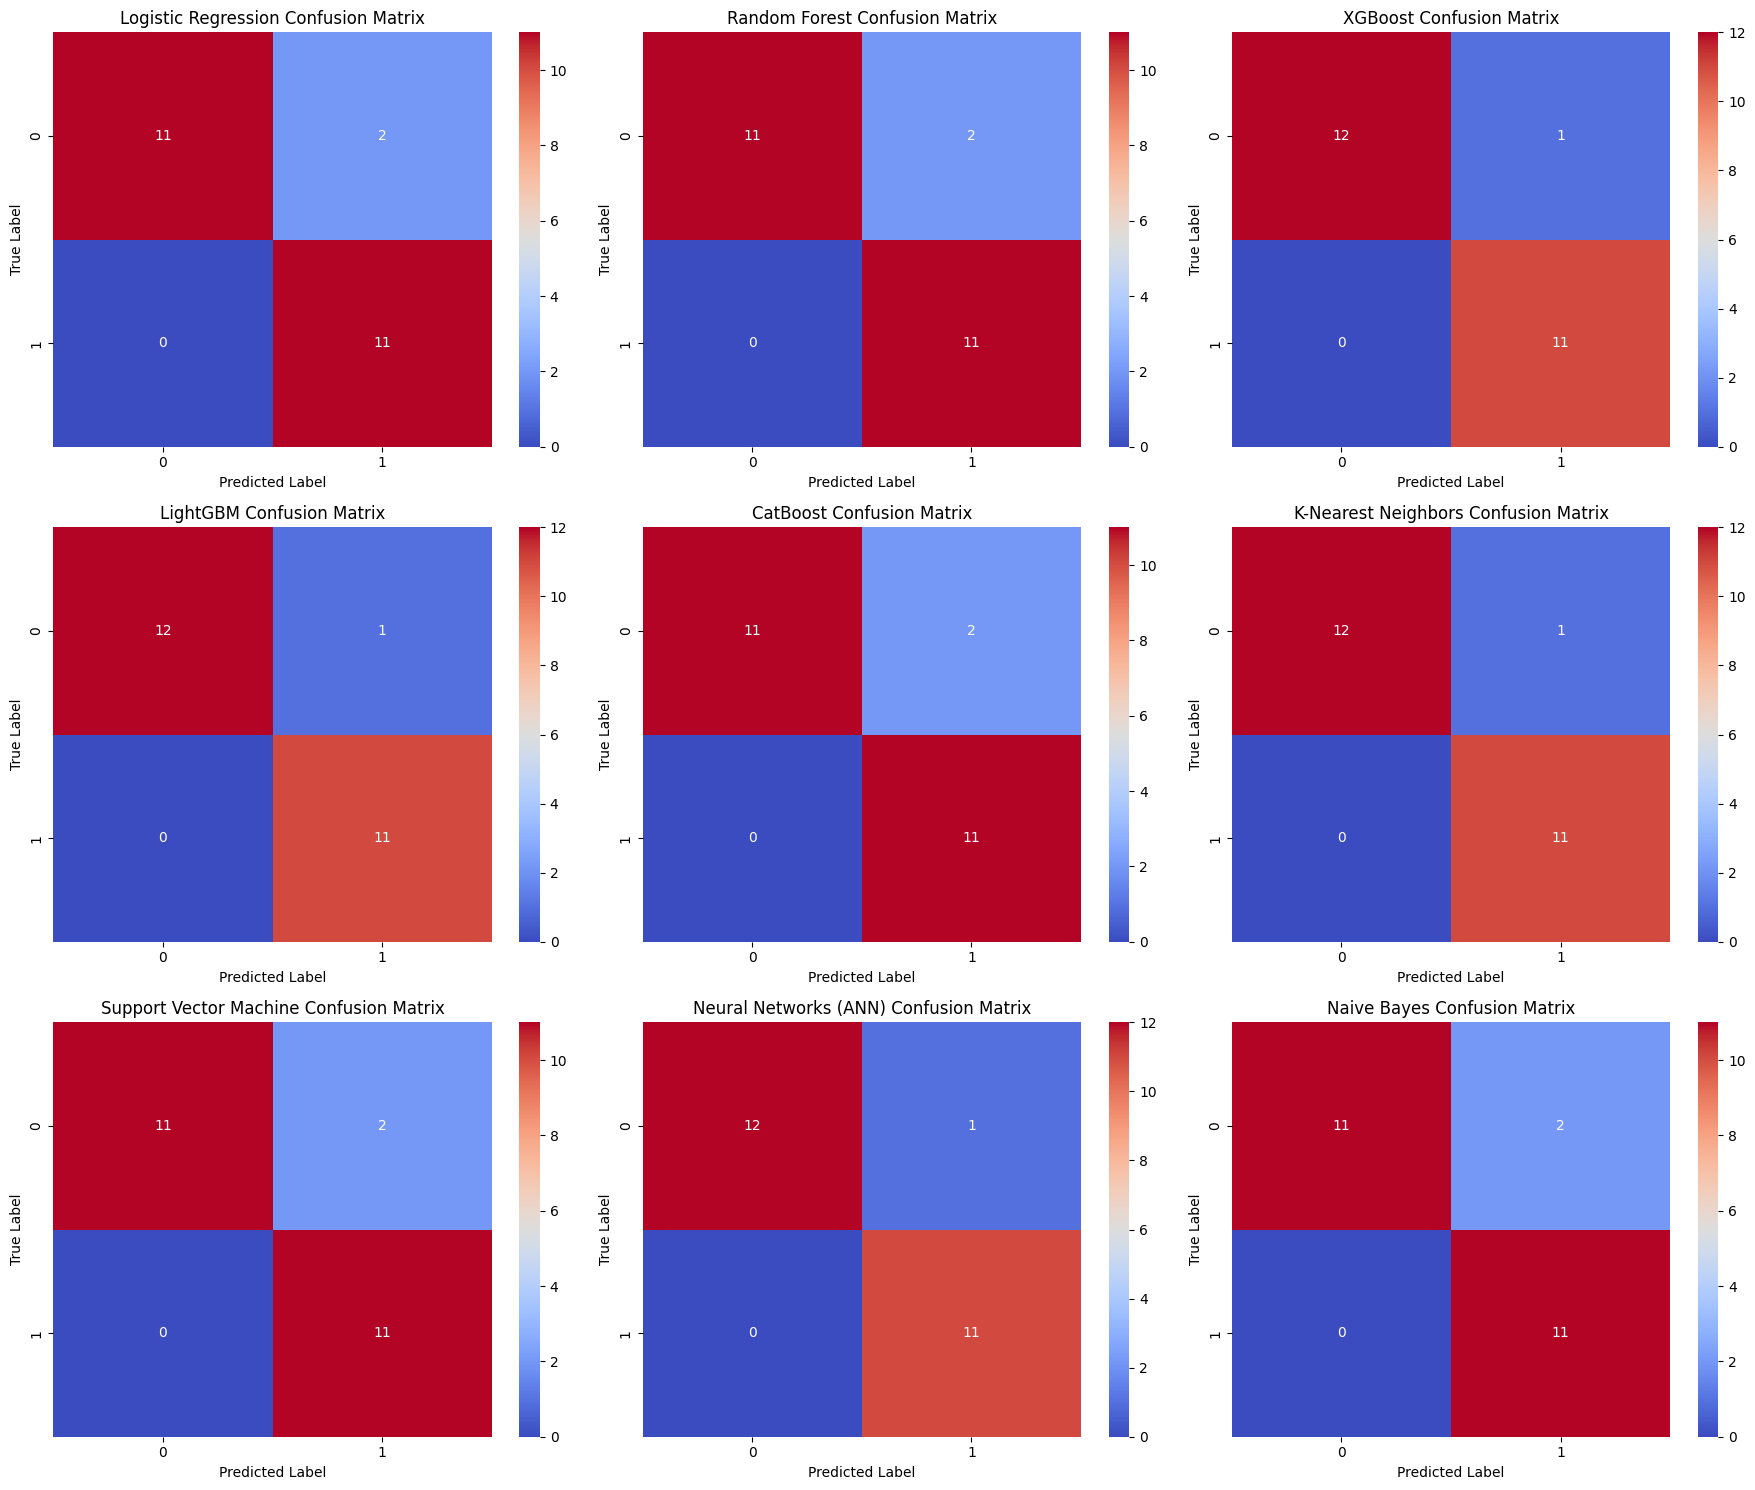

<Figure size 1200x800 with 0 Axes>

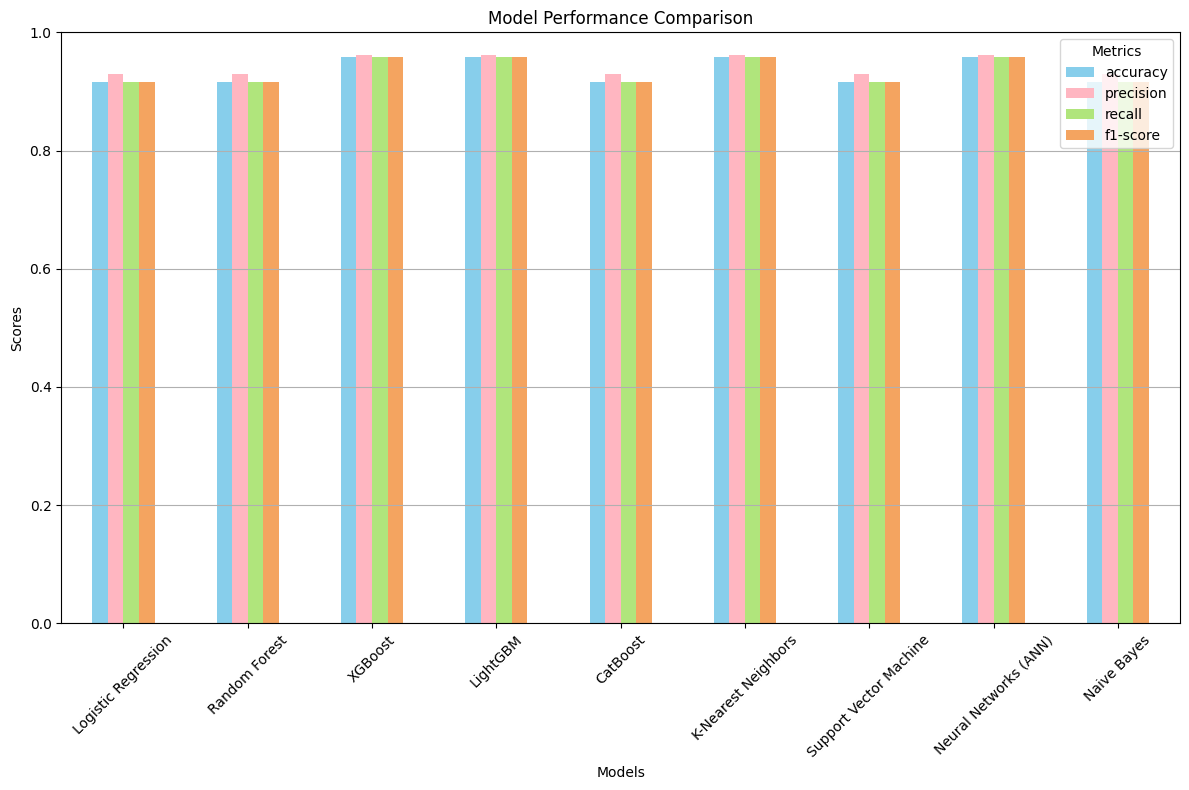

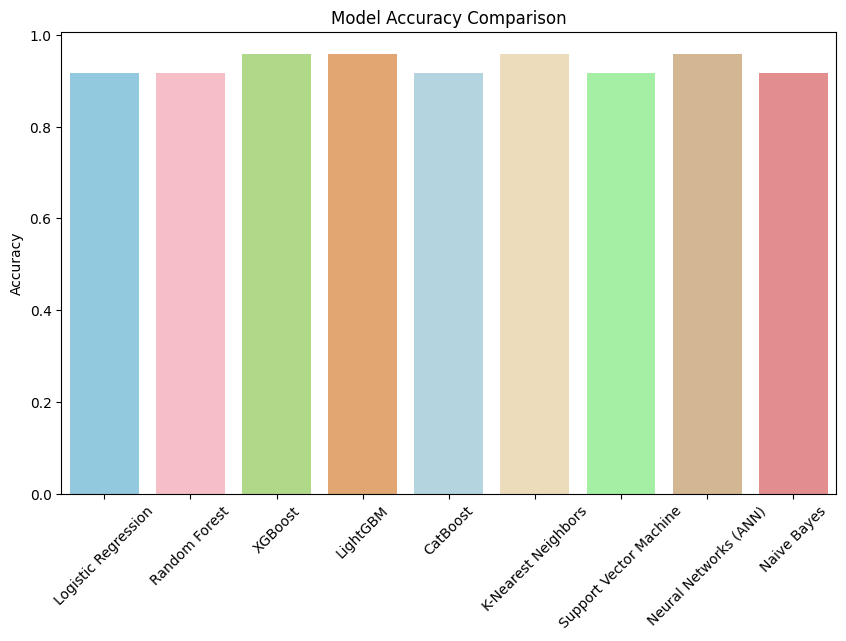

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load and prepare dataset (replace with actual dataset loading)
# Example:
# df = pd.read_csv('your_dataset.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# Encode target labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train models
log_reg = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lgbm = LGBMClassifier()
catboost = CatBoostClassifier(verbose=0)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', probability=True)
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nb = GaussianNB()

models = {
    'Logistic Regression': log_reg,
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'CatBoost': catboost,
    'K-Nearest Neighbors': knn,
    'Support Vector Machine': svm,
    'Neural Networks (ANN)': ann,
    'Naive Bayes': nb
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Step 2: Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Step 3: Generate confusion matrix for each model
def plot_confusion_matrices(y_test, predictions, model_names, label_encoder):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))  # Adjust grid size for 9 models
    axes = axes.flatten()

    for i, (model_name, y_pred) in enumerate(predictions.items()):
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[i])
        axes[i].set_title(f'{model_name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Step 4: Plot all confusion matrices together
plot_confusion_matrices(y_test, predictions, models.keys(), label_encoder)

# Step 5: Visualize model performance (Accuracy, Precision, Recall, F1-Score)
performance_metrics = {}

for model_name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    performance_metrics[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }

# Convert performance metrics to DataFrame
performance_df = pd.DataFrame(performance_metrics).T

# Step 6: Plot metrics with moderate colors
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
colors = ['#87CEEB', '#FFB6C1', '#B0E57C', '#F4A460', '#ADD8E6', '#F5DEB3', '#98FB98', '#DEB887', '#F08080']

plt.figure(figsize=(12, 8))
performance_df[metrics].plot(kind='bar', color=colors)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Metrics')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Step 7: Summarize accuracy for all models
model_accuracies = {model_name: accuracy_score(y_test, y_pred) for model_name, y_pred in predictions.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


Training Artificial Neural Networks...


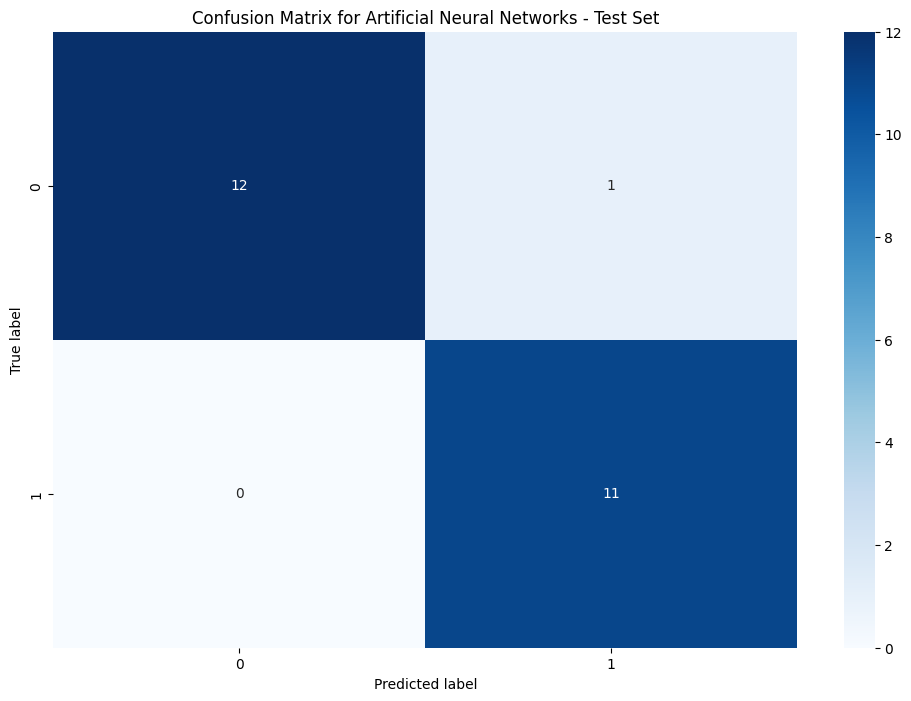

Training k-Nearest Neighbour...


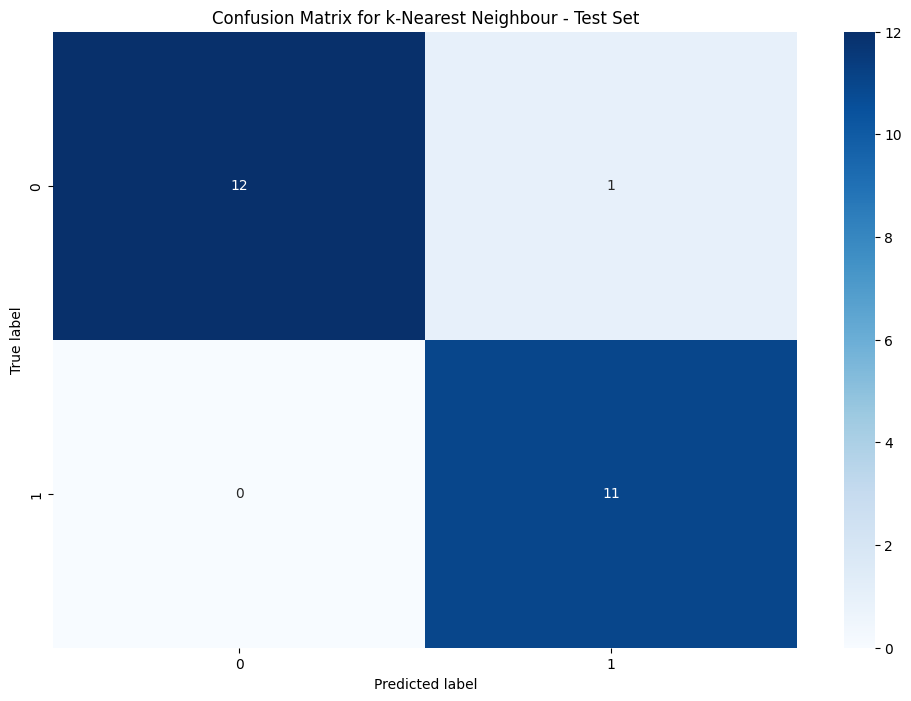

Training Random Forest...


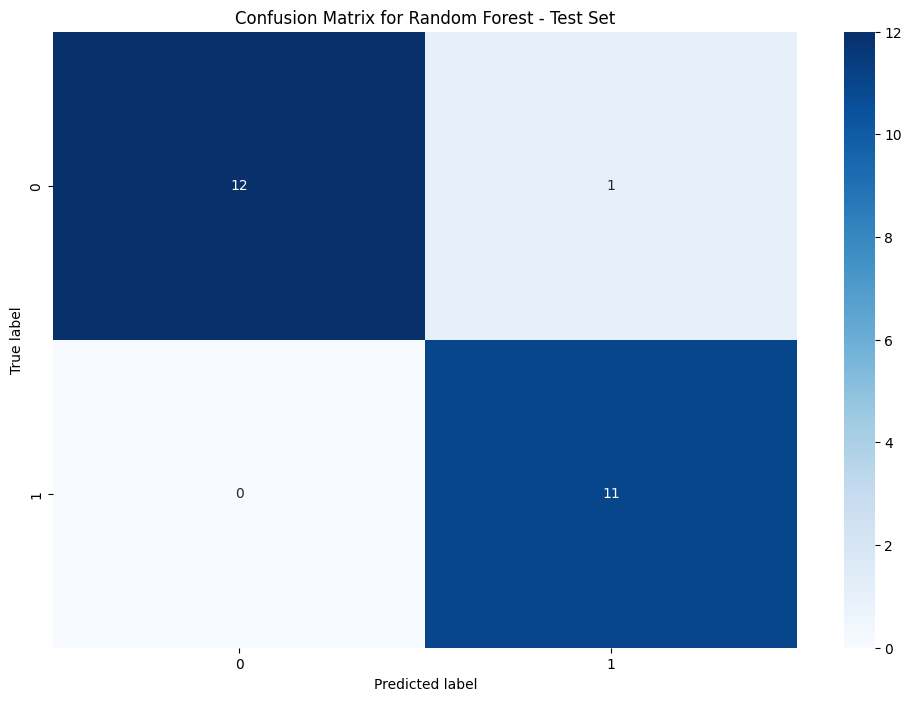

Training LogisticRegression...


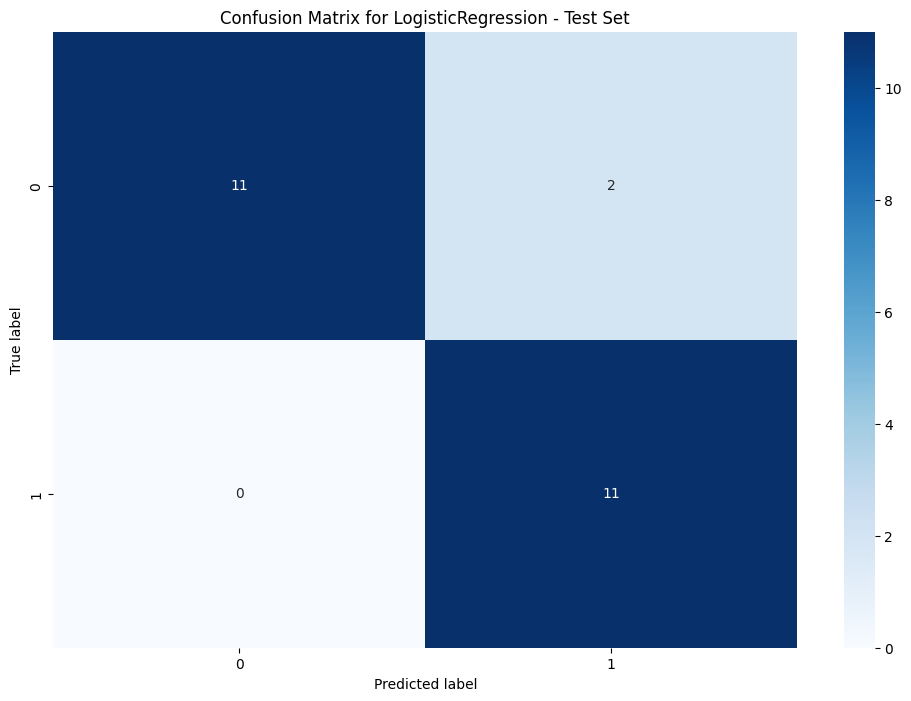

Training XGBoost...


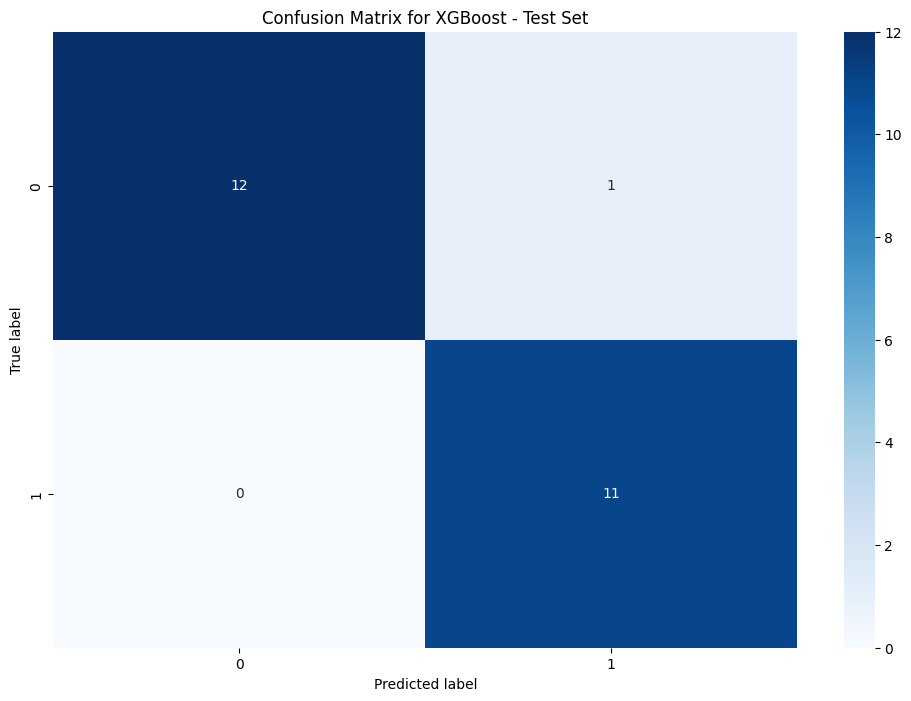

Training SVC...


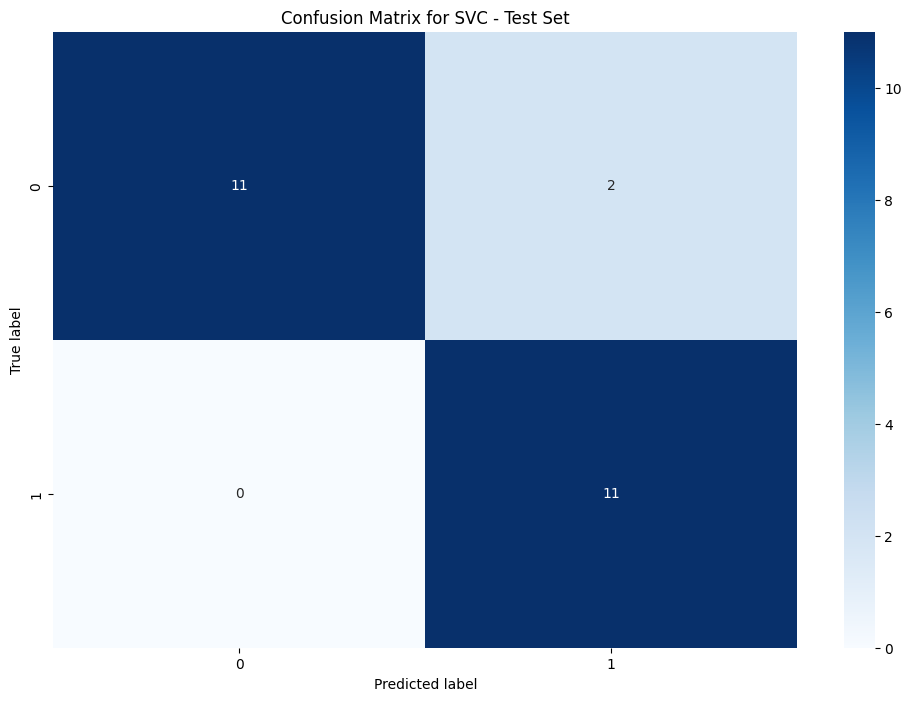

                            train_accuracy  test_accuracy  train_f1_score  \
Artificial Neural Networks        1.000000       0.958333        1.000000   
k-Nearest Neighbour               0.979167       0.958333        0.979167   
Random Forest                     1.000000       0.958333        1.000000   
LogisticRegression                0.989583       0.916667        0.989582   
XGBoost                           1.000000       0.958333        1.000000   
SVC                               0.979167       0.916667        0.979158   

                            test_f1_score  train_precision  test_precision  \
Artificial Neural Networks       0.958406         1.000000        0.961806   
k-Nearest Neighbour              0.958406         0.979167        0.961806   
Random Forest                    0.958406         1.000000        0.961806   
LogisticRegression               0.916667         0.989796        0.929487   
XGBoost                          0.958406         1.000000        0.96

In [ ]:
models = {
    'Artificial Neural Networks': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),  # ANN model
    'k-Nearest Neighbour': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'SVC': SVC(kernel='linear', probability=True),
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)


    # Calculate accuracy, precision, recall, and F1-score
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    # Store the results
    results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall
    }

    # Confusion Matrix for the test set
    cm = confusion_matrix(y_test, y_test_pred)
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} - Test Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


results_df = pd.DataFrame(results).T


print(results_df)


Training Artificial Neural Networks...


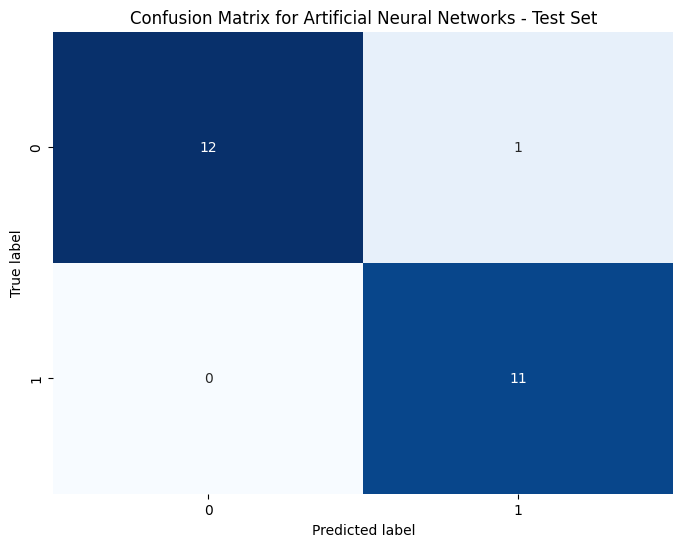

Training k-Nearest Neighbour...


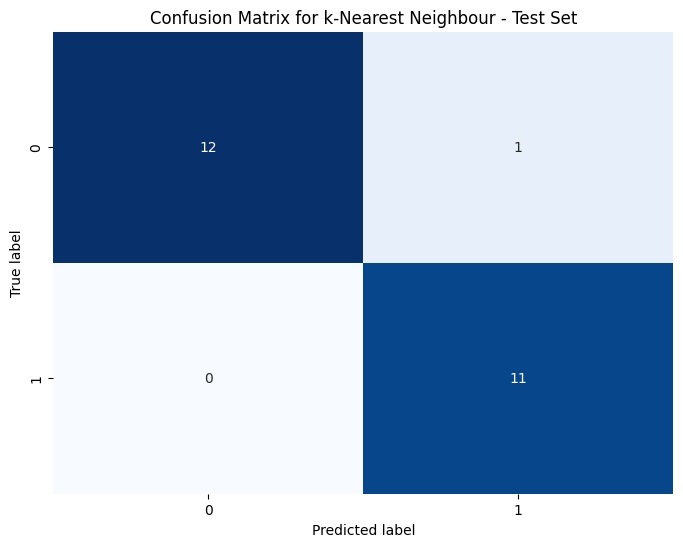

Training Random Forest...


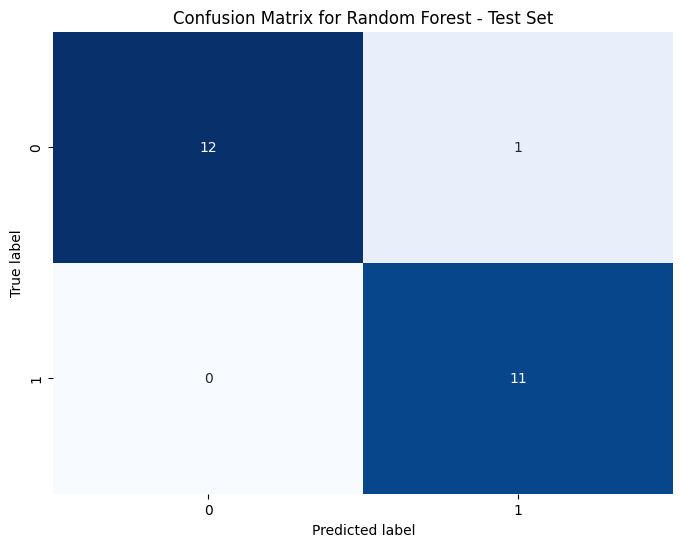

Training Logistic Regression...


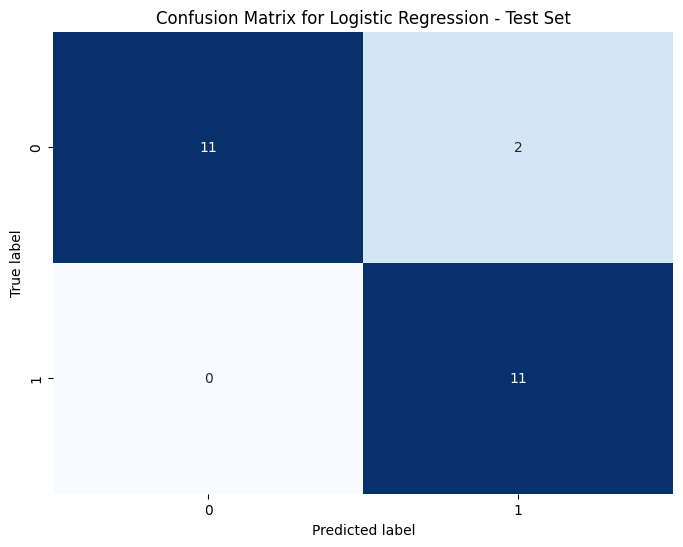

Training XGBoost...


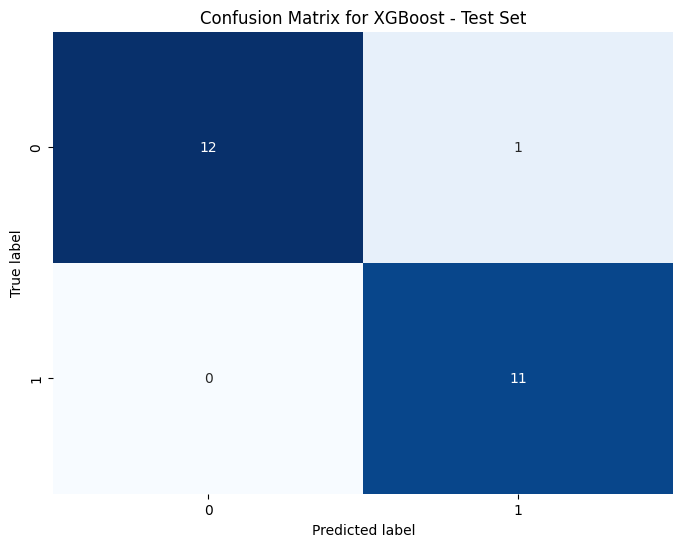

Training Support Vector Classifier...


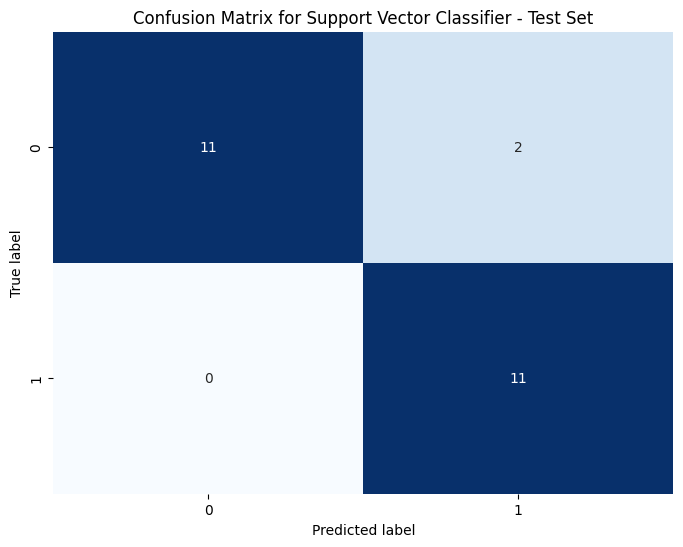

Training Naive Bayes...


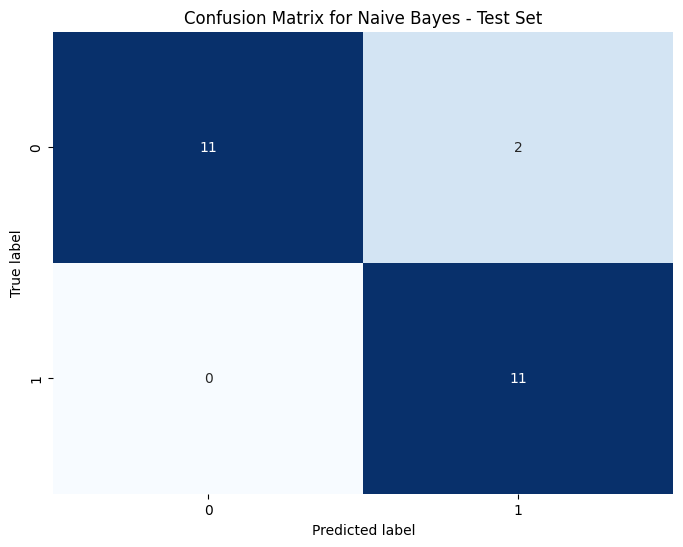

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 48, number of negative: 48
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

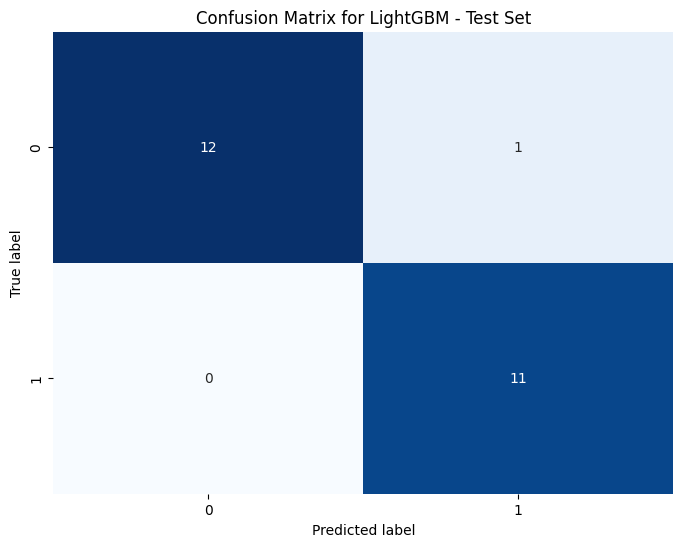

Training CatBoost...


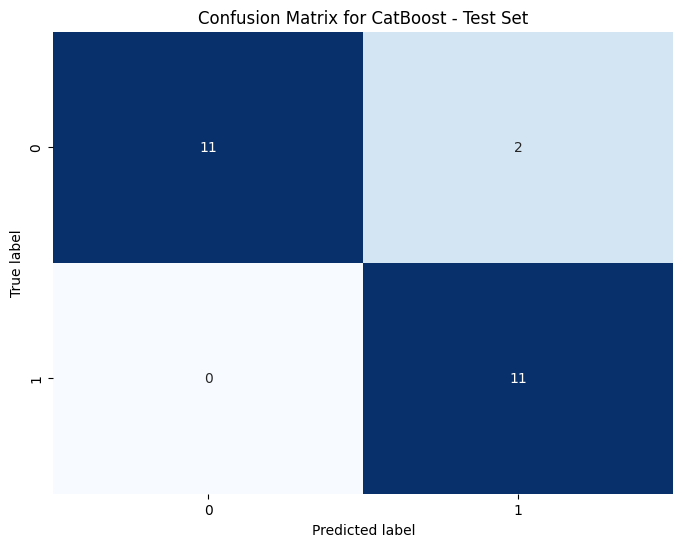

                            train_accuracy  test_accuracy  train_f1_score  \
Artificial Neural Networks        1.000000       0.958333        1.000000   
k-Nearest Neighbour               0.979167       0.958333        0.979167   
Random Forest                     1.000000       0.958333        1.000000   
Logistic Regression               0.989583       0.916667        0.989582   
XGBoost                           1.000000       0.958333        1.000000   
Support Vector Classifier         0.979167       0.916667        0.979158   
Naive Bayes                       0.979167       0.916667        0.979158   
LightGBM                          1.000000       0.958333        1.000000   
CatBoost                          1.000000       0.916667        1.000000   

                            test_f1_score  train_precision  test_precision  \
Artificial Neural Networks       0.958406         1.000000        0.961806   
k-Nearest Neighbour              0.958406         0.979167        0.96180

In [ ]:
# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier  # Ensure you have installed catboost
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define models including Naive Bayes, LightGBM, and CatBoost
models = {
    'Artificial Neural Networks': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'k-Nearest Neighbour': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Support Vector Classifier': SVC(kernel='linear', probability=True),
    'Naive Bayes': GaussianNB(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True)  # Set silent=True to suppress warnings during training
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    train_precision = precision_score(y_train_resampled, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_recall = recall_score(y_train_resampled, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    # Store the results
    results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall
    }

    # Confusion Matrix for the test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name} - Test Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Create a DataFrame for the results
results_df = pd.DataFrame(results).T
print(results_df)


In [ ]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport
import webbrowser
# Create a profile report
profile = ProfileReport(X, title="Pandas Profiling Report")

# Save the report to a file
profile.to_file('/content/drive/MyDrive/1_data_ml/modified_flood_ydata.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X.duplicated().sum()

0

In [ ]:
import pickle

# Save the trained model as a file
with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.pkl', 'wb') as file:
    pickle.dump(model, file)


Training Artificial Neural Networks...


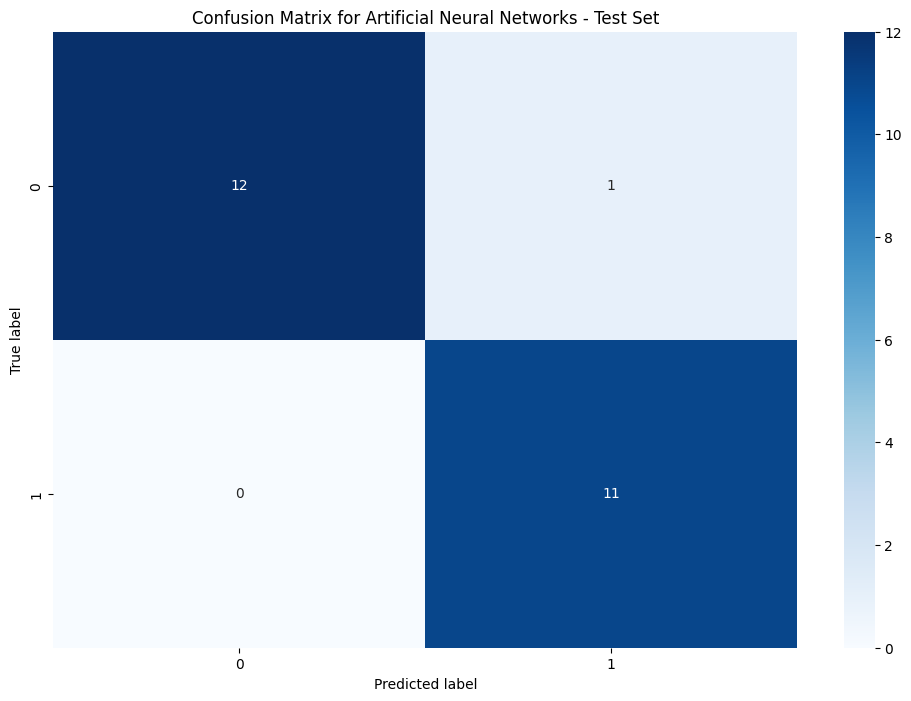

Training k-Nearest Neighbour...


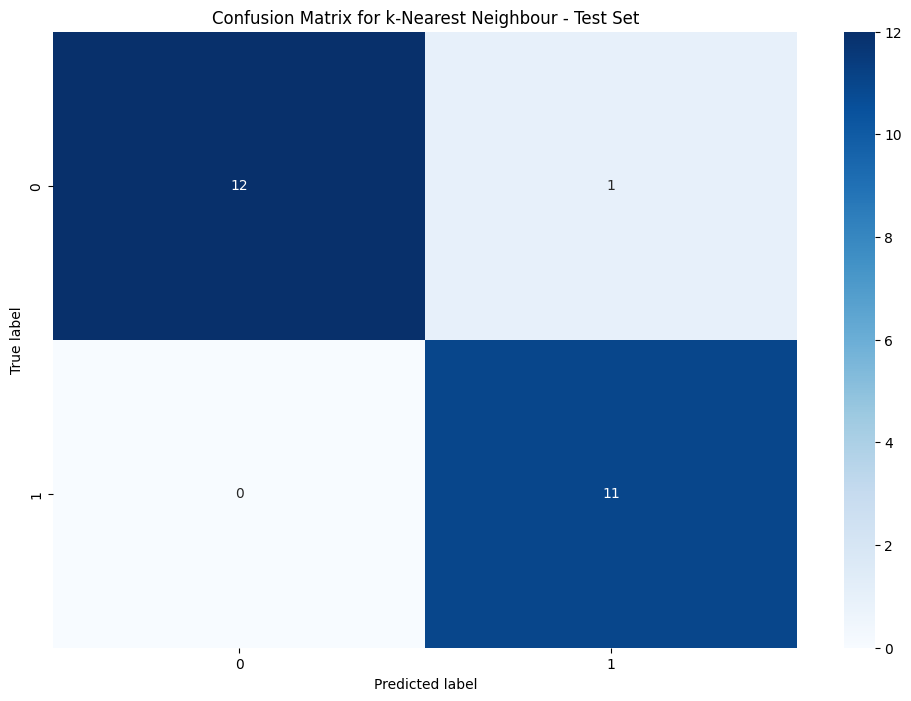

Training Random Forest...


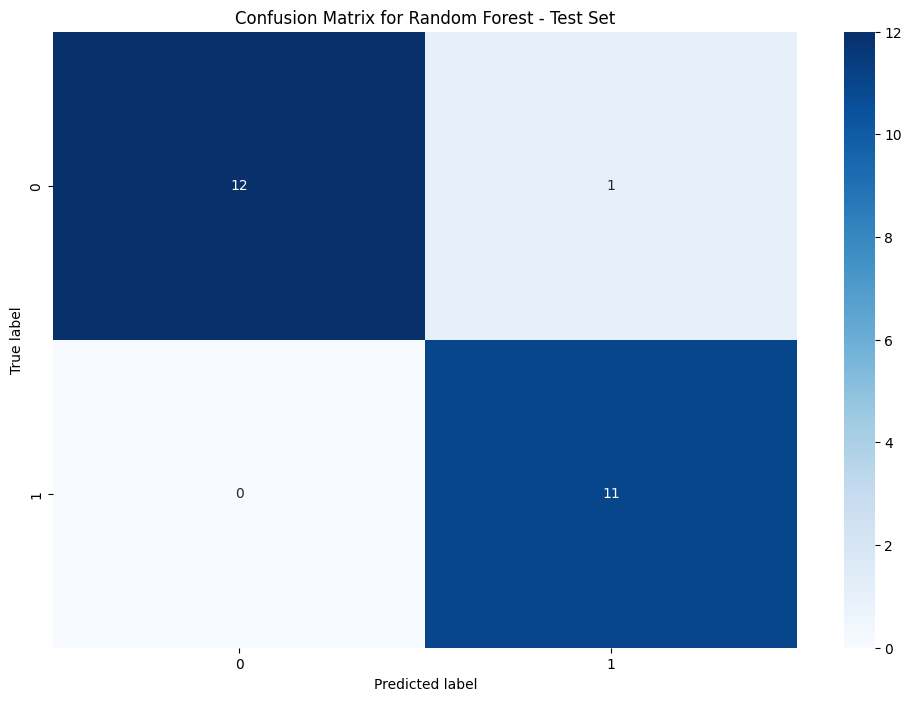

Training Logistic Regression...


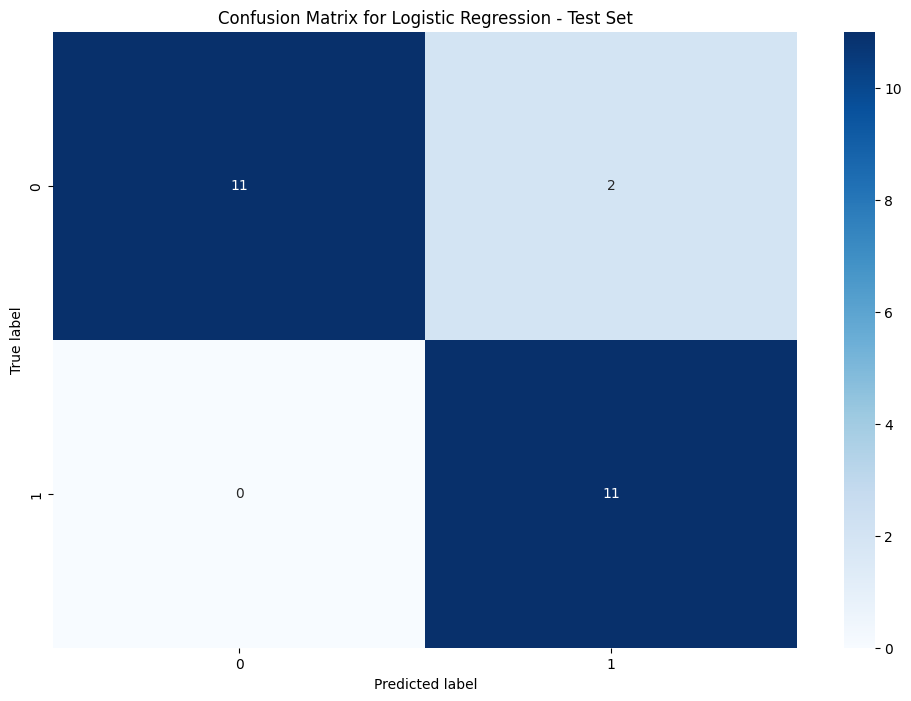

Training XGBoost...


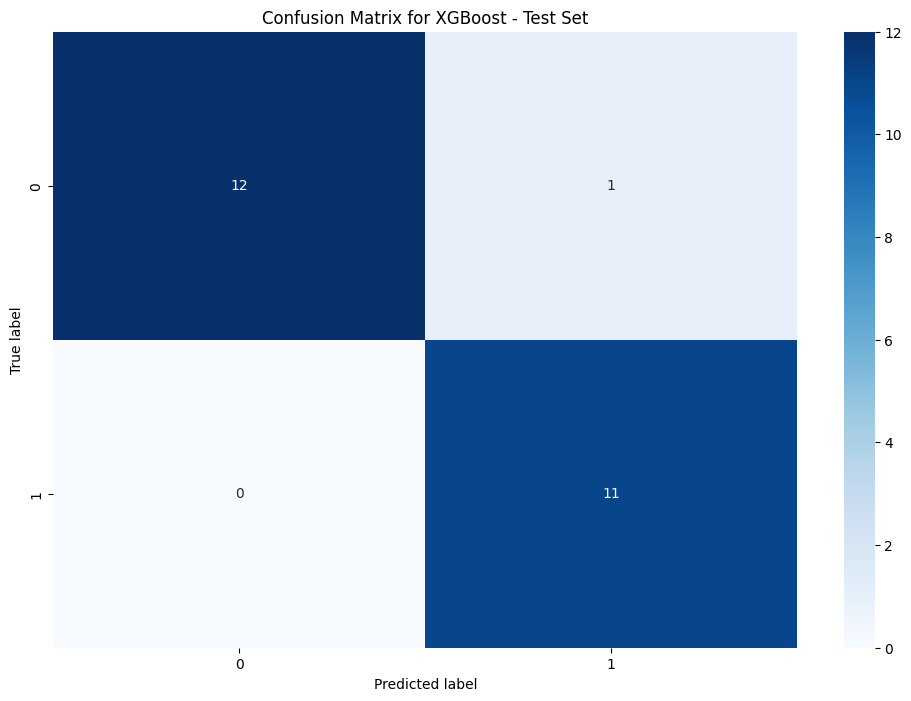

Training Support Vector Classifier...


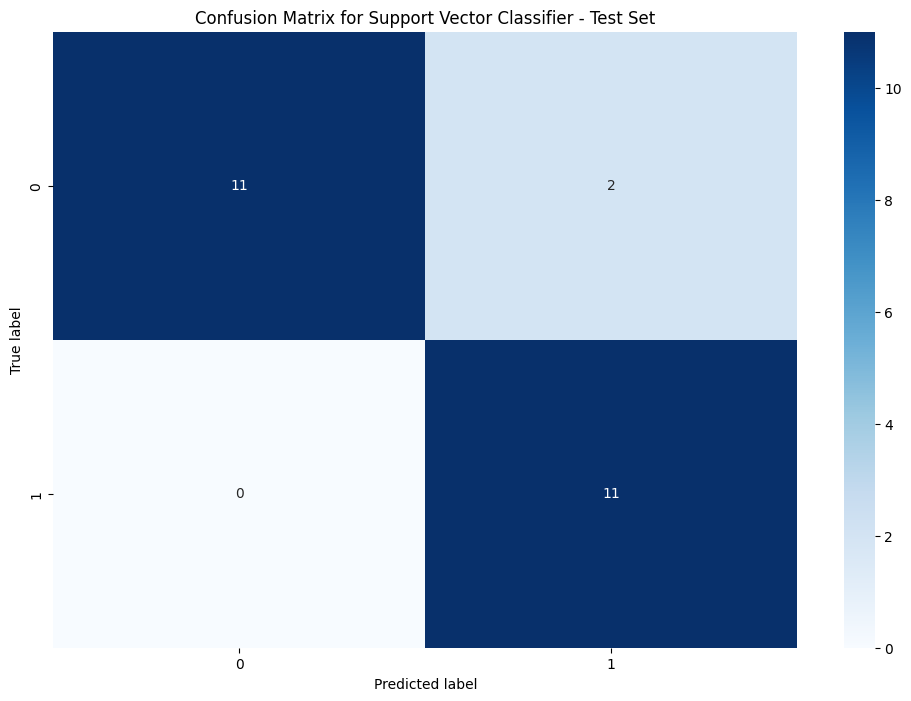

Training Naive Bayes...


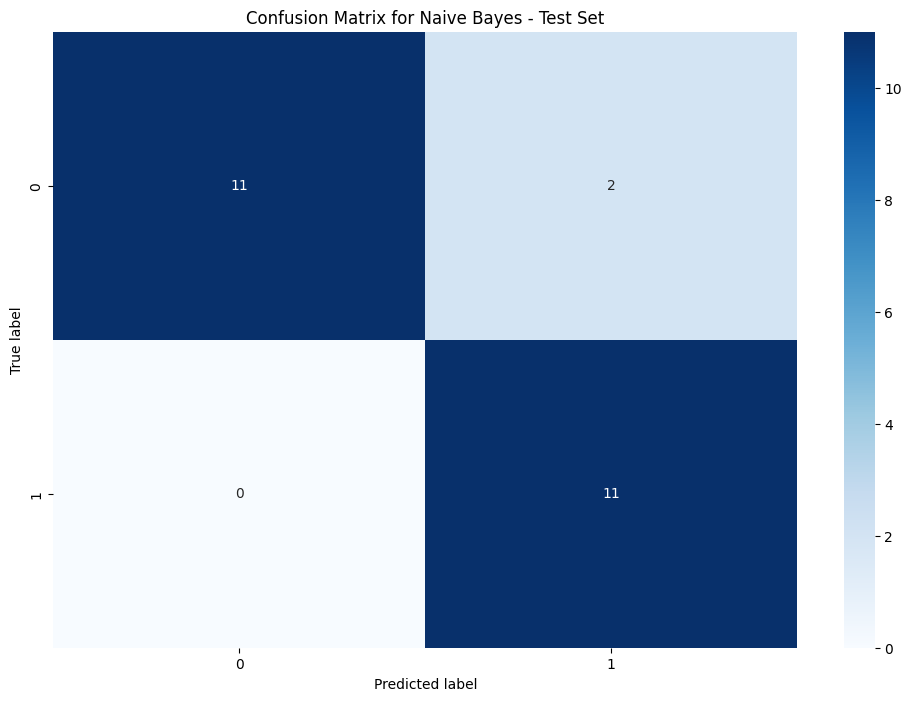

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 48, number of negative: 48
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

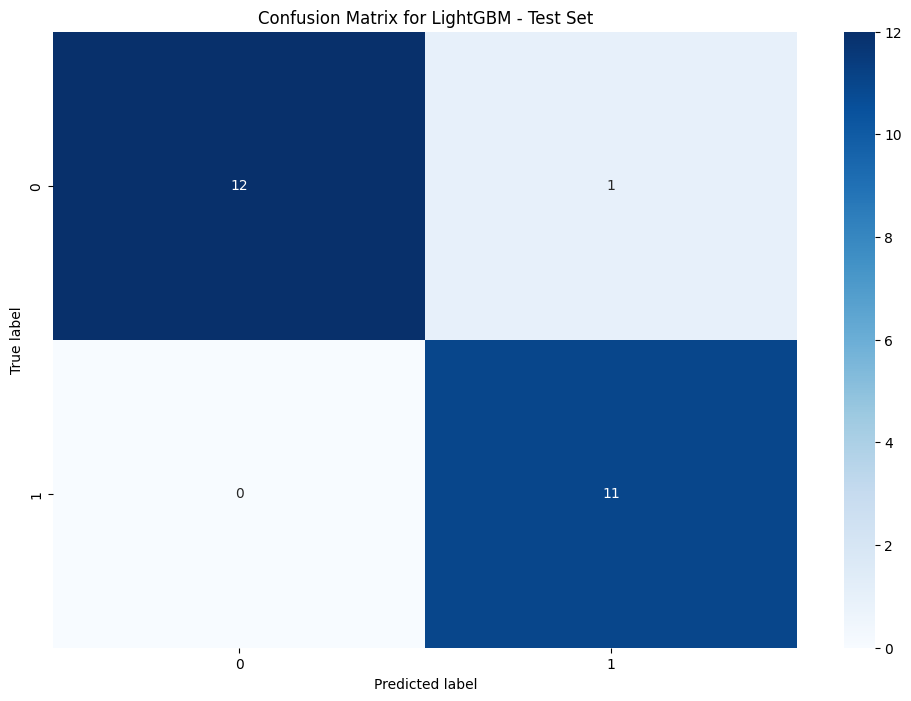

Training CatBoost...


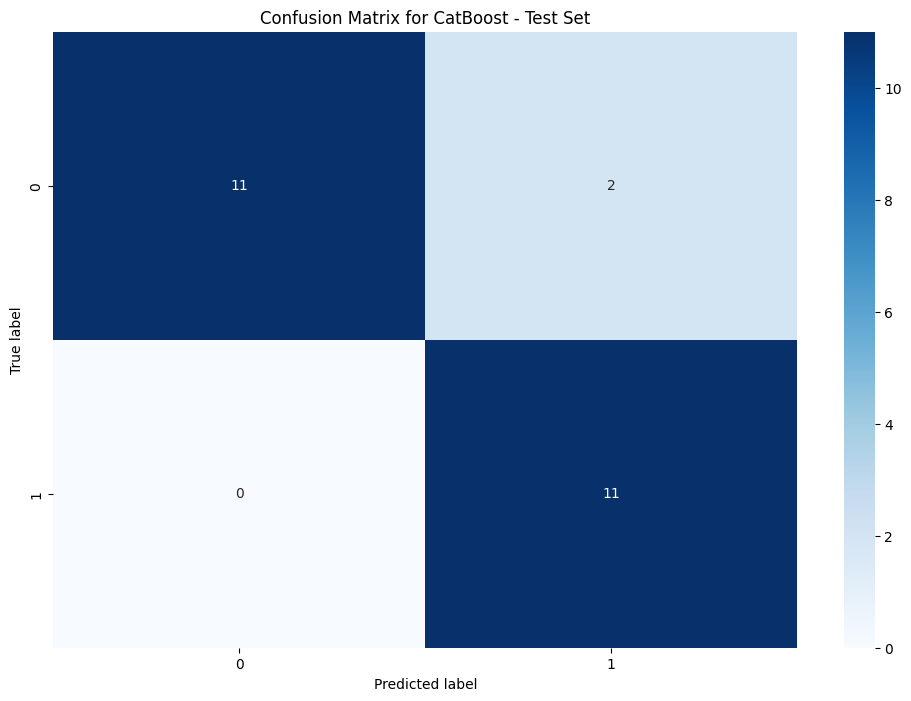

Best model saved!


In [ ]:
import pickle

# ... (rest of your code)

results = {}
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Check if this model is the best one so far
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model  # Store the best model

    # Store the results
    results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        # ... other metrics
    }

    # Confusion Matrix for the test set
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} - Test Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Save the best model
if best_model is not None:
    with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.pkl', 'wb') as file:
        pickle.dump(best_model, file)

print("Best model saved!")


In [ ]:
import pickle

with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.pkl', 'rb') as file:
    best_model = pickle.load(file)


In [ ]:
import pandas as pd


new_sample_data = {
    'Watery stool': 0,
    'dehydration': 1,
    'abdominal_cramps': 0,

    'vomiting': 1,
    'fatigue': 0,
    'fever': 1,
    'rice_water_stool': 1,
    'leg_cramps': 0,
    'rapid_heart_rate': 0
}


new_sample_df = pd.DataFrame([new_sample_data])


new_sample_df = new_sample_df[X.columns]

In [ ]:
# Make predictions on the new sample
predictions = best_model.predict(new_sample_df)
predicted_probabilities = best_model.predict_proba(new_sample_df)

decoded_predictions = label_encoder.inverse_transform(predictions)

predicted_class_index = predictions[0]
predicted_percentage = predicted_probabilities[0][predicted_class_index] * 100


if decoded_predictions[0] == '0':
    print(f"Predicted Disease: Cholera")
else:
    print(f"Predicted Disease: Diarrhea")

print(f"Confidence: {predicted_percentage:.2f}%")


Predicted Disease: Diarrhea
Confidence: 88.67%


In [ ]:
pip install matplotlib seaborn


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.5084 - loss: 0.7353 - val_accuracy: 0.6316 - val_loss: 0.6590
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5980 - loss: 0.6625 - val_accuracy: 0.6842 - val_loss: 0.5946
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6798 - loss: 0.6021 - val_accuracy: 0.8421 - val_loss: 0.5376
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7934 - loss: 0.5488 - val_accuracy: 0.8421 - val_loss: 0.4865
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8869 - loss: 0.5007 - val_accuracy: 0.8421 - val_loss: 0.4400
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9421 - loss: 0.4567 - val_accuracy: 0.8947 - val_loss: 0.3978
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9789 - loss: 0.4156 - val_accuracy: 0.9474 - val_loss: 0.3597
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9789 - loss: 0.3774 - val_accuracy: 1.0000 - val_loss

Saved artifact at '/tmp/tmpo3r957f1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138663538764512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663328333888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663376587760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663534408128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663534404256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663378352288: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow model trained and converted to TFLite successfully.
--- Random Forest ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy        

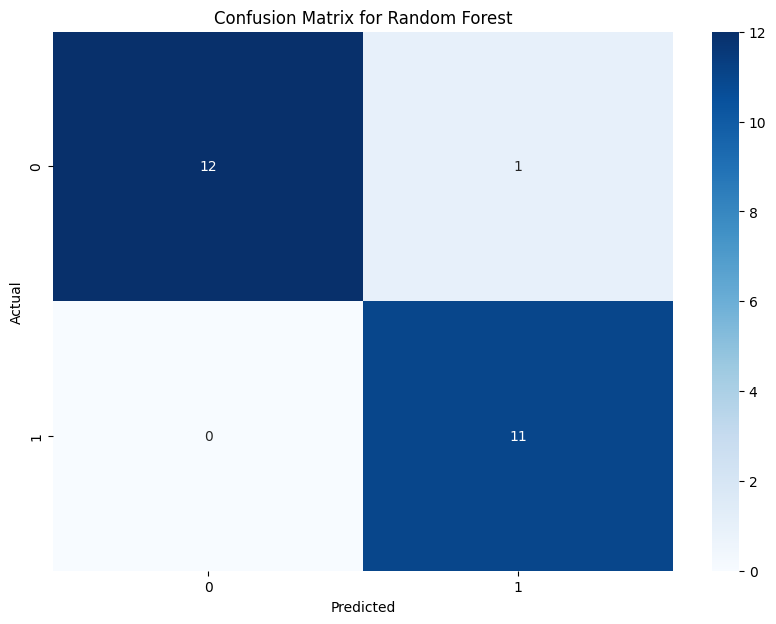

------------------------------
--- Logistic Regression ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



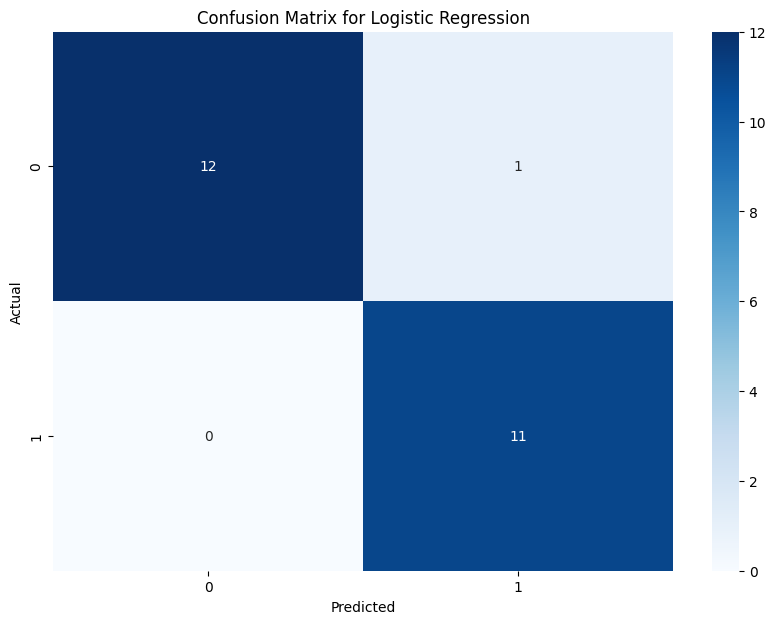

------------------------------
--- XGBoost ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



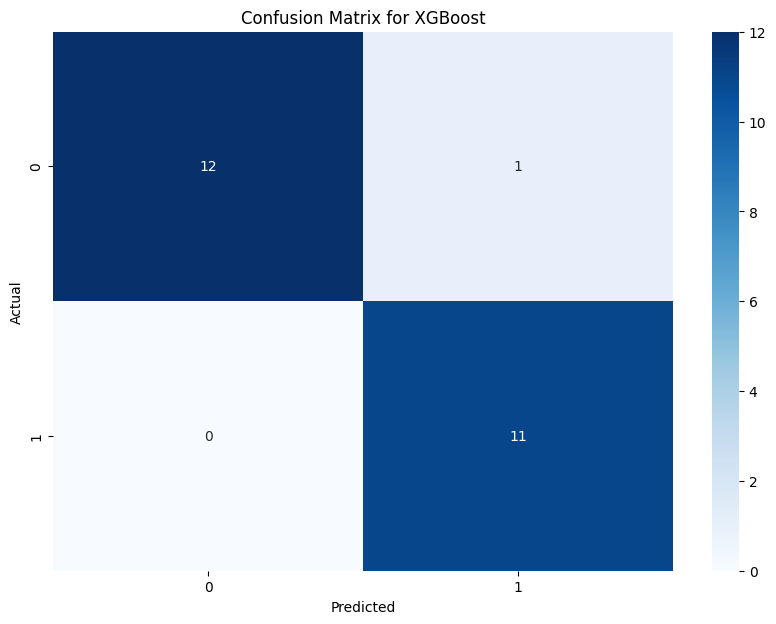

------------------------------
--- K-Nearest Neighbors ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



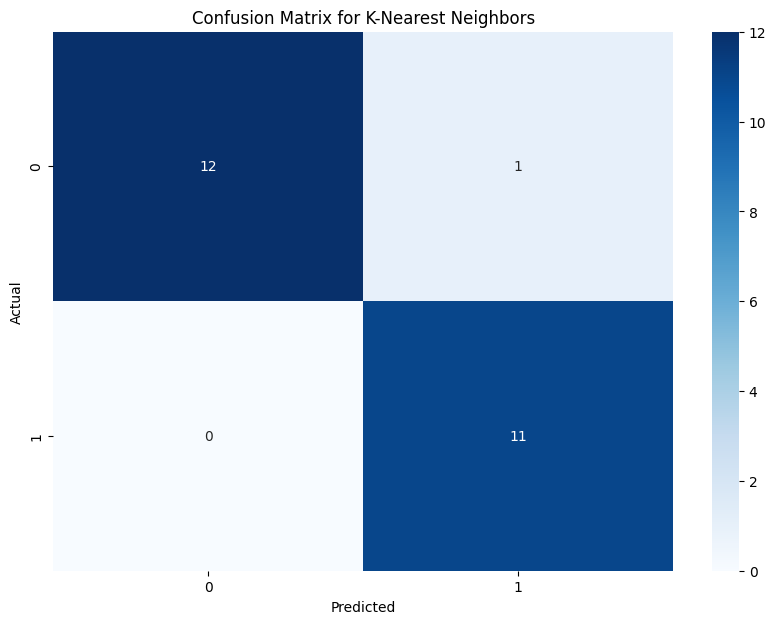

------------------------------
--- Support Vector Machine ---
Accuracy: 0.9167
F1 Score: 0.9167
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.85      1.00      0.92        11

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24



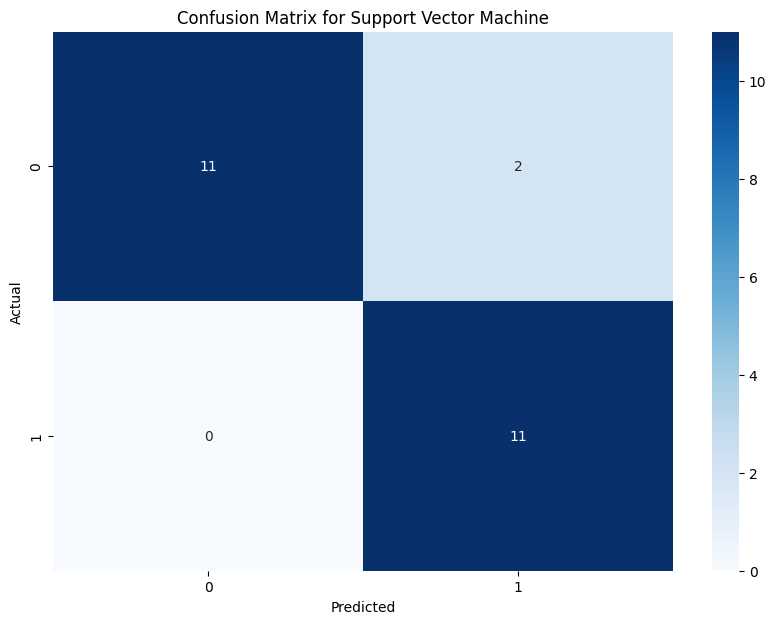

------------------------------
--- Multi-layer Perceptron ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



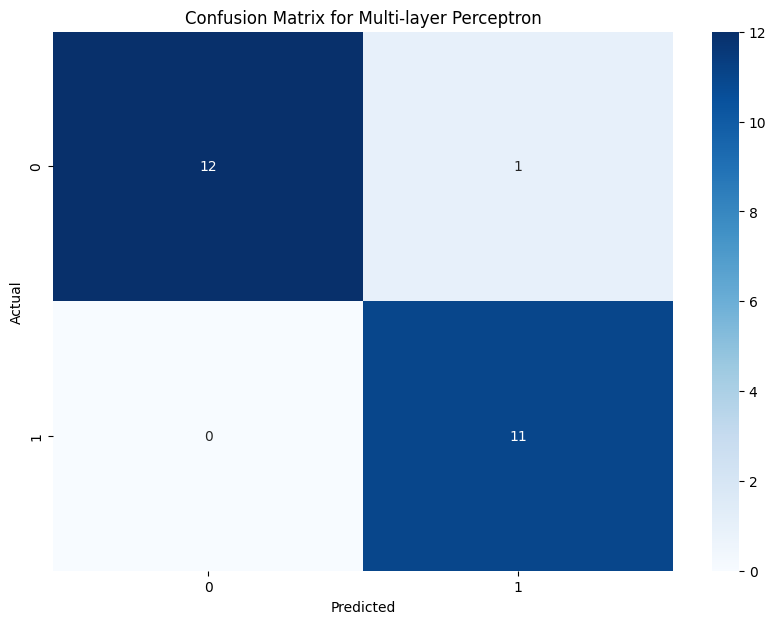

------------------------------


In [ ]:
import numpy as np
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Assuming you have already preprocessed X and y
# X, y = ... (Load your dataset here)

# Split the dataset into training and testing sets
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),              # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),              # Hidden layer 2
    tf.keras.layers.Dense(len(np.unique(y_train_resampled)), activation='softmax')  # Output layer
])

# Compile the TensorFlow model
model_tf.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the TensorFlow model
model_tf.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2)

# Save the TensorFlow model
model_tf.save('/content/drive/MyDrive/1_data_ml/model_flood_disease_tf.h5')

# Convert the TensorFlow model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow model trained and converted to TFLite successfully.")

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Multi-layer Perceptron': MLPClassifier(max_iter=200, random_state=42)
}

# Train, predict, and evaluate each classifier
for name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train_scaled, y_train_resampled)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("-" * 30)

# Note: Set random seed globally at the start of the code to ensure consistency across models and TensorFlow


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4666 - loss: 0.7193 - val_accuracy: 0.5789 - val_loss: 0.6468
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6231 - loss: 0.6466 - val_accuracy: 0.5789 - val_loss: 0.5895
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6826 - loss: 0.5961 - val_accuracy: 0.7895 - val_loss: 0.5389
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7483 - loss: 0.5410 - val_accuracy: 0.8947 - val_loss: 0.4944
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8391 - loss: 0.4888 - val_accuracy: 1.0000 - val_loss: 0.4533
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8106 - loss: 0.4673 - val_accuracy: 1.0000 - val_loss: 0.4159
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9115 - loss: 0.4039 - val_accuracy: 1.0000 - val_loss: 0.3801
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9288 - loss: 0.3715 - val_accuracy: 1.0000 - val_loss

Saved artifact at '/tmp/tmpvks6j1mf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138663543829984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663543830688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663536409968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663536408208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663536400816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663536406448: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow model trained and converted to TFLite successfully.
--- Random Forest ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy        

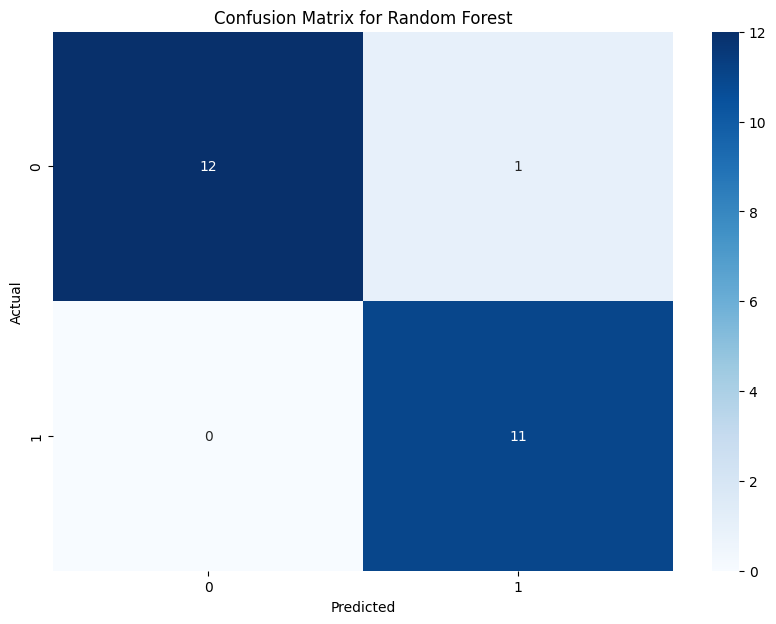

------------------------------
--- Logistic Regression ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



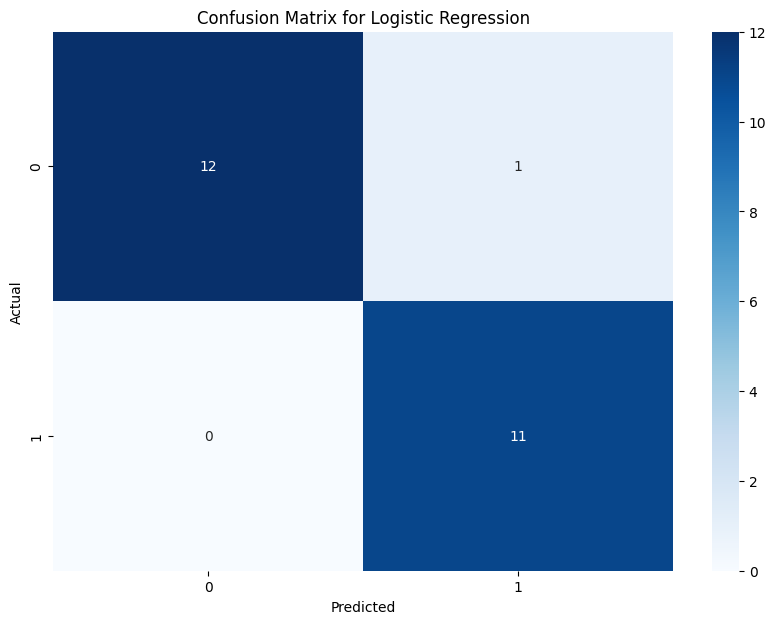

------------------------------
--- XGBoost ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



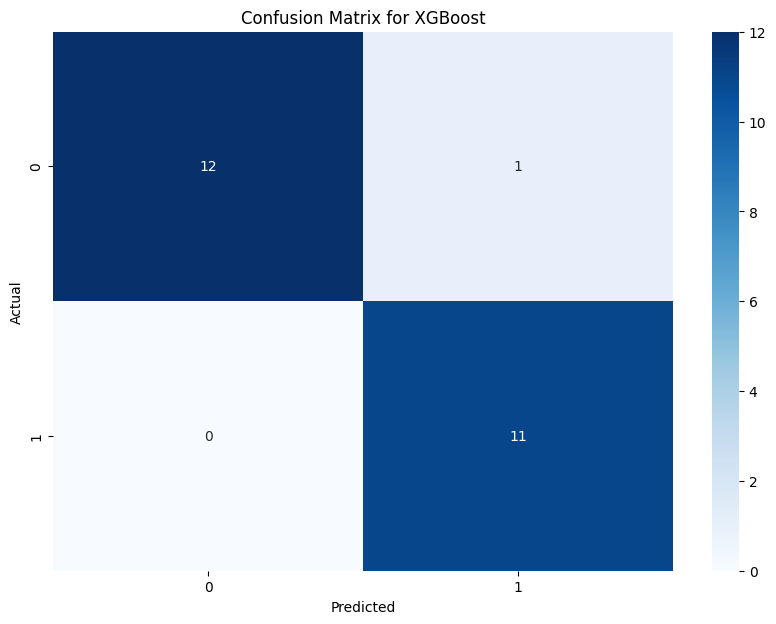

------------------------------
--- K-Nearest Neighbors ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



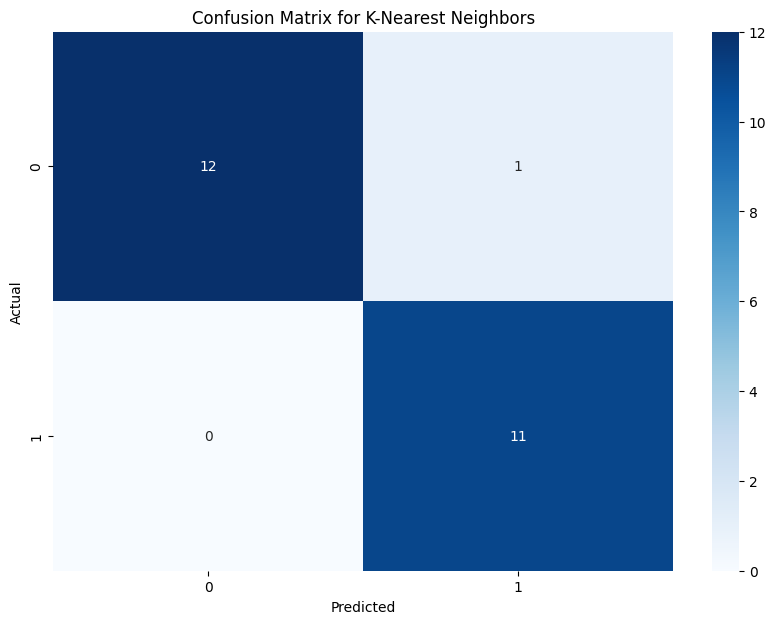

------------------------------
--- Support Vector Machine ---
Accuracy: 0.9167
F1 Score: 0.9167
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.85      1.00      0.92        11

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24



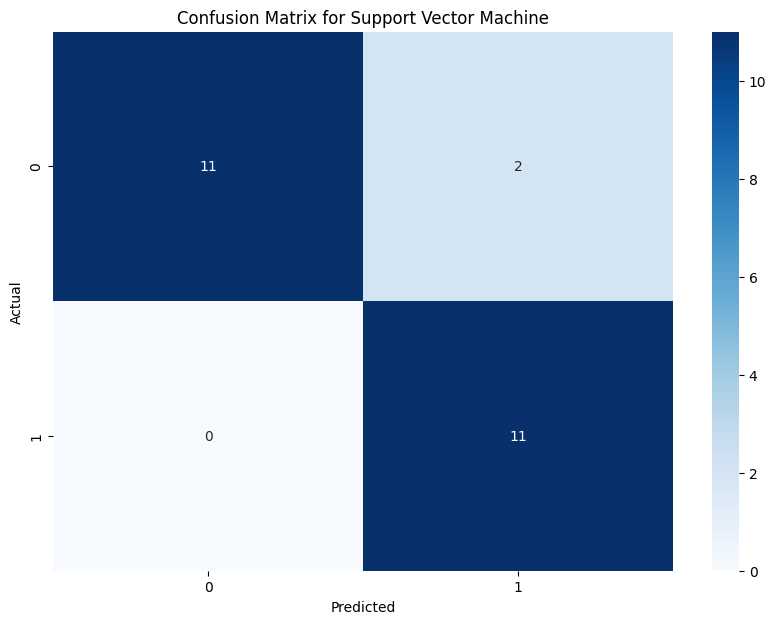

------------------------------
--- Multi-layer Perceptron ---
Accuracy: 0.9583
F1 Score: 0.9584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.92      1.00      0.96        11

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



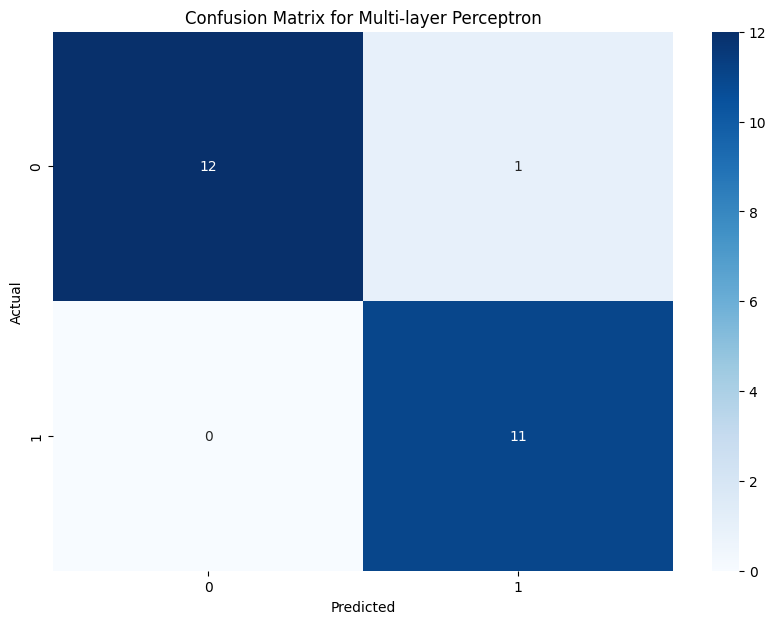

------------------------------


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already preprocessed X and y
# X, y = ... (Load your dataset here)

# Split the dataset into training and testing sets
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),              # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),              # Hidden layer 2
    tf.keras.layers.Dense(len(np.unique(y_train_resampled)), activation='softmax')  # Output layer
])

# Compile the TensorFlow model
model_tf.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the TensorFlow model
model_tf.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2)

# Save the TensorFlow model
model_tf.save('/content/drive/MyDrive/1_data_ml/model_flood_disease_tf.h5')

# Convert the TensorFlow model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow model trained and converted to TFLite successfully.")

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Multi-layer Perceptron': MLPClassifier(max_iter=200, random_state=42)
}

# Train, predict, and evaluate each classifier
for name, clf in classifiers.items():
    # Fit the model
    clf.fit(X_train_scaled, y_train_resampled)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print classification report
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("-" * 30)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Assuming you have already preprocessed X_train_resampled and y_train_resampled

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the TensorFlow model
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    tf.keras.layers.Dense(64, activation='relu'),              # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'),              # Hidden layer 2
    tf.keras.layers.Dense(len(np.unique(y_train_resampled)), activation='softmax')  # Output layer
])

# Compile the model
model_tf.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
model_tf.fit(X_train_scaled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2)

# Save the model
model_tf.save('/content/drive/MyDrive/1_data_ml/model_flood_disease_tf.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_tf)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/1_data_ml/model_flood_disease.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow model trained and converted to TFLite successfully.")


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.3534 - loss: 0.7947 - val_accuracy: 0.4000 - val_loss: 0.7396
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4097 - loss: 0.7230 - val_accuracy: 0.5500 - val_loss: 0.6863
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5197 - loss: 0.6584 - val_accuracy: 0.6500 - val_loss: 0.6371
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7251 - loss: 0.5925 - val_accuracy: 0.6500 - val_loss: 0.5906
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8168 - loss: 0.5575 - val_accuracy: 0.8000 - val_loss: 0.5464
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9305 - loss: 0.4914 - val_accuracy: 0.8500 - val_loss: 0.5054
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9058 - loss: 0.4718 - val_accuracy: 0.9000 - val_loss: 0.4668
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9293 - loss: 0.4060 - val_accuracy: 0.9500 - val_loss

Saved artifact at '/tmp/tmp0m53yk6t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138663328429712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663328426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663328429008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663328430416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663328430240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138663066697968: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow model trained and converted to TFLite successfully.


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf

# Load the TFLite model
model_path = '/content/drive/MyDrive/1_data_ml/model_flood_disease.tflite'  # Replace with your model's path
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()


In [ ]:
# Check if the model was loaded correctly
print(interpreter.get_input_details())
print(interpreter.get_output_details())


[{'name': 'serving_default_keras_tensor_1:0', 'index': 0, 'shape': array([1, 9], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 7, 'shape': array([0, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
input_details = interpreter.get_input_details()
print(input_details)  # Print to verify the expected input shape


[{'name': 'serving_default_keras_tensor_1:0', 'index': 0, 'shape': array([1, 9], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
test_input_data = np.random.rand(*input_shape).astype(np.float32)  # Normalized random data


In [ ]:
if output_data.shape[0] > 0:
    predicted_class_index = np.argmax(output_data[0])  # Get the index of the highest score
    predicted_probability = output_data[0][predicted_class_index] * 100  # Convert to percentage
    print(f"Predicted Class Index: {predicted_class_index}")
    print(f"Predicted Probability: {predicted_probability:.2f}%")
else:
    print("No output data available for predictions.")


No output data available for predictions.


In [ ]:
interpreter.invoke()
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output Data Shape:", output_data.shape)  # Print shape to debug


Output Data Shape: (0, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder if not already done

# Assuming label_encoder is already defined and fitted. For example:
# label_encoder = LabelEncoder()
# label_encoder.fit(your_labels)  # Ensure to fit it on your dataset's labels

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/1_data_ml/model_flood_disease.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare your input data (example symptoms)
new_sample_data = {
   'Watery stool': 1,
    'dehydration': 1,
    'abdominal_cramps': 1,

    'vomiting': 1,
    'fatigue': 0,
    'fever': 1,
    'rice_water_stool': 1,
    'leg_cramps': 1,
    'rapid_heart_rate': 1
}

# Convert the input data to a NumPy array with the right shape
input_data = np.array([[new_sample_data['Watery stool'],
                        new_sample_data['dehydration'],
                        new_sample_data['abdominal_cramps'],
                        new_sample_data['vomiting'],
                        new_sample_data['fatigue'],
                        new_sample_data['fever'],
                        new_sample_data['rice_water_stool'],
                        new_sample_data['leg_cramps'],
                        new_sample_data['rapid_heart_rate']]], dtype=np.float32)

# Check expected input shape
expected_input_shape = input_details[0]['shape']
print(f"Expected Input Shape: {expected_input_shape}")

# Ensure input data shape matches the model input shape
if input_data.shape[1] != expected_input_shape[1]:  # Check only the number of features
    interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)
    interpreter.allocate_tensors()

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Invoke the interpreter
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Check output data size and print the predictions safely
if output_data.size > 0:
    predicted_class_index = np.argmax(output_data[0])  # Get the index of the highest score
    predicted_probability = output_data[0][predicted_class_index] * 100  # Convert to percentage

    # Decode the prediction
    decoded_prediction = label_encoder.inverse_transform([predicted_class_index])

    print(f"Predicted Disease: {decoded_prediction[0]}")
    print(f"Confidence: {predicted_probability:.2f}%")
else:
    print("No output data available for predictions.")


Expected Input Shape: [1 9]
Predicted Disease: cholera
Confidence: 75.71%
